# **Notebook Summary**

This notebook improves on the previous by moving the **feature extractor** into the dataset generator itself, streamlining data processing.

It introduces **mixup augmentation** applied directly on the **spectrogram features** (instead of raw audio), where two samples with non-overlapping bird labels are randomly combined using Beta-distributed weights. This encourages the model to learn from blended feature-level examples, improving generalization.

Additionally, **SpecAugment** is applied on the spectrogram features, performing time and frequency masking to simulate challenging acoustic conditions.

The dataset also continues to apply diverse audio augmentations like reverberation, compression, pitch shifting, time stretching, time shifting, volume changes, and clipping randomly to increase data variability.

A key improvement was incorporating samples from **train_audio** where BirdNET did not predict the assigned primary label but where the Google Bird Vocalization Classifier provided confident alternative predictions. These samples were added to the training data to increase label reliability and improve model performance.

Data loading uses a custom collate function that batches the extracted features and corresponding multi-label targets.

Overall, these changes optimize training efficiency and model robustness by integrating augmentations at the feature extraction level and leveraging advanced data mixing techniques.


# **Imports**

In [1]:
from google.colab import drive
import zipfile
import os
import pandas as pd
import joblib
import ast
import numpy as np
import warnings
import random
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset, DataLoader
import librosa
from collections import defaultdict
from transformers import AutoFeatureExtractor, AutoModel

import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, label_ranking_average_precision_score
import torch.optim as optim
import torch.nn.functional as F
from google.colab import runtime


drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Main_Birdclef/scripts')
import birdclef_utils





Mounted at /content/drive


# **Get Data From Drive**
- Retreive the birdclef-2025 training data
- Retreive other processed data

In [2]:
birdclef_utils.retrieve_and_process_birdclef_data()
birdclef_utils.retrieve_and_process_birdclef_data(zip_filename='ColabUploads.zip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully extracted all files from birdclef-2025.zip to /content/data
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully extracted all files from ColabUploads.zip to /content/data


# **Directories**

In [3]:
main_dir='/content/data/'
main_processed_dir=os.path.join(main_dir,'ColabUploads')
processed_dir=os.path.join(main_processed_dir,'KaggleUploads')

drive_dir='/content/drive/MyDrive'
main_birdclef_dir=os.path.join(drive_dir,'Main_Birdclef')
csv_dir=os.path.join(main_birdclef_dir,'CSVs')
supplemental_files_dir=os.path.join(main_birdclef_dir,'supplemental_files')
models_dir=os.path.join(main_birdclef_dir,'models')

# **Processed csv and label encoder**
- CSV is derived from train.csv provided by birdclef.  It contains additional columns such as the duration of each audio file and the number of files associated with each species.

In [4]:
warnings.filterwarnings('ignore')
df = pd.read_csv(os.path.join(processed_dir,'speech_cleaned_audio_with_duration.csv'), dtype={'primary_label': 'object'})
df['secondary_labels'] = df['secondary_labels'].apply(ast.literal_eval)

# Path to the label encoder file
label_encoder_path = os.path.join(supplemental_files_dir,'bird_label_encoder.joblib')

try:
    # Load the label encoder
    label_encoder = joblib.load(label_encoder_path)
    print(f"Successfully loaded label_encoder from: {label_encoder_path}")
except FileNotFoundError:
    print(f"Error: File not found at: {label_encoder_path}. "
          f"Please ensure the dataset 'processing-models' is attached and the path is correct.")

Successfully loaded label_encoder from: /content/drive/MyDrive/Main_Birdclef/supplemental_files/bird_label_encoder.joblib


# **Data Split**

Training, validation, and testing sets were created by splitting on filename.

## Original Split
- **Training:** 16,985
- **Validation:** 3,016
- **Testing:** 8,574
- **Soundscapes:** 1,698 reserved for potential validation and testing
- **Soundscapes:** 8,028 potentially used for training

## Modifications
- 4,000 files were transferred from the testing set to the training set
- 2,819 soundscape files were added to the training set

## Final File Counts
- **Training:** 22,904
- **Validation:** 3,016
- **Testing:** 4,574


In [5]:
original_train_filenames=np.load(os.path.join(processed_dir,'train_filenames.npy'))
original_test_filenames=np.load(os.path.join(processed_dir,'test_filenames.npy'))
original_val_filenames=np.load(os.path.join(processed_dir,'val_filenames.npy'))
added_fnames=[f for f in original_test_filenames[:4000]]
original_train_filenames=list(original_train_filenames)+added_fnames
original_test_filenames=original_test_filenames[4000:]
print('Length of Train Filenames: ',len(original_train_filenames))

file_mapping=df.set_index('cleaned_filename')['filename'].to_dict()
original_train_filenames=[file_mapping[f] for f in original_train_filenames]
original_val_filenames=[file_mapping[f] for f in original_val_filenames]
original_test_filenames=[file_mapping[f] for f in original_test_filenames]

# Birdnet Predictions for all train_soundscape files and all birds considered
labeled_soundscapes=pd.read_csv(os.path.join(csv_dir, 'birdnet_soft_labels.csv'))
labeled_soundscapes.rename(columns={'file':'filename'},inplace=True)

training_labeled_soundscape_fnames=labeled_soundscapes['filename'].unique()[:3000]
validation_testing_soundscapes=labeled_soundscapes['filename'].unique()[3000:]
labeled_soundscapes_filtered=labeled_soundscapes[labeled_soundscapes['confidence']>0.35]
labeled_soundscape_fnames_filtered=labeled_soundscapes_filtered['filename'].unique()

soundscapes_to_add_to_training=[f for f in labeled_soundscape_fnames_filtered if f in training_labeled_soundscape_fnames]
print(f"Length of Added Training Soundscapes: {len(soundscapes_to_add_to_training)}")

original_train_filenames=original_train_filenames+soundscapes_to_add_to_training
negative_soundscapes=pd.read_csv(os.path.join(csv_dir,'birdnet_negative_samples_data_revised.csv'))
negative_soundscapes_fnames=negative_soundscapes['filename'].unique()
new_num_lab_soundscapes=pd.read_csv(os.path.join(csv_dir,'numeric_labels_soundscapes.csv'))
new_num_lab_soundscapes_fnames=new_num_lab_soundscapes['filename'].unique()
added_num_lab_soundscapes=[f for f in new_num_lab_soundscapes_fnames if f not in validation_testing_soundscapes]
added_neg_soundscapes=[f for f in negative_soundscapes_fnames if f not in validation_testing_soundscapes]
print('Length Added non-birdnet label Soundscapes: ', len(added_num_lab_soundscapes))
print('Length Added Negative Soundscapes: ', len(added_neg_soundscapes))
original_train_filenames=original_train_filenames+added_neg_soundscapes+added_num_lab_soundscapes
print('\nFinal Sizes')

print('\tFinal Length of Train Filenames: ',len(original_train_filenames))
print('\tFinal Length of Val Filenames: ',len(original_val_filenames))
print('\tFinal Length of Test Filenames: ',len(original_test_filenames))

Length of Train Filenames:  20985
Length of Added Training Soundscapes: 1344
Length Added non-birdnet label Soundscapes:  145
Length Added Negative Soundscapes:  100

Final Sizes
	Final Length of Train Filenames:  22574
	Final Length of Val Filenames:  3016
	Final Length of Test Filenames:  4574


# **Pseudo‑Labeling**

The `retrieveData` class provides hard and soft labels for given filenames and start times, using a variety of CSV files containing pseudo‑labels generated from BirdNET and custom models.

## Pseudo‑Label Sources

### BirdNET‑Derived
- **`birdnet_train_labels_final.csv`**  
  BirdNET confidences for all assigned *primary labels* in `train_audio`.
- **`birdnet_secondary_label_detections.csv`**  
  BirdNET confidences for all assigned *secondary labels* in `train_audio`.
- **`birdnet_soft_labels.csv`**  
  BirdNET confidences for `train_soundscapes`.

### Non‑BirdNET Model‑Derived
- **`non_birdnet_confidences_from_softmax.csv`**  
  Confidences for assigned primary labels **not in BirdNET training data**, generated using a custom model trained on random start times (`train_audio`).
- **`non_birdnet_confidences_from_softmax_short_files.csv`**  
  Additional confidences for primary labels **not in BirdNET classes** from shorter audio files (`train_audio`).
- **`added_secondary_labels_non_birdnet.csv`**  
  Confidences for assigned secondary labels in classes **not in BirdNET classes**.
- **`non_birdnet_confidences_from_MAE.csv`**  
  Confidences for non‑BirdNET classes from the MAE model after training on `train_audio`.

### Special Cases & Corrections
- **`birdnet_negative_samples_data.csv`**  
  Filenames and start times for birds **not in BirdCLEF‑2025 classes** but given high confidence by BirdNET — used as *negative samples*.
- **`rows_to_replace1.csv`**  
  Data believed to be misclassified by BirdNET, likely because the true label is actually a non‑BirdNET class.

## Other Supporting Files
- **`birdnet_confidence_thresholds.npy`**  
  Per‑class thresholds used to decide if a label should be converted to a **hard label**.

## Methodology
1. Run BirdNET on all **primary labels** in `train_audio` to obtain confidences.
2. For each bird species, compute the **lower quartile** of all confidences across the dataset.
3. Use this value as a class‑specific **confidence threshold**:
   - For `train_soundscapes`: convert soft labels to *hard labels* if the confidence exceeds the threshold.
   - For `train_audio`: all assigned primary labels are converted to hard labels by default.
4. Non‑BirdNET class confidences are generated using custom models (Softmax classifier, MAE model) trained on `train_audio`.



| Dataset Variable                    | Description                                                                                                                                                | File Example                             | Window Size (seconds) | Label Type                     | Confidence / Prediction Source             |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------|----------------------|--------------------------------|--------------------------------------------|
| `start_time_info`                 | BirdNET predictions for assigned primary labels in train_audio, using 3-second sliding windows                                                            | `birdnet_train_labels_final.csv`        | 3                    | Primary labels                | BirdNET confidence                         |
| `start_time_info_secondary_labels` | BirdNET predictions for assigned secondary labels, also with 3-second sliding windows                                                                     | `birdnet_secondary_label_detections.csv` | 3                    | Secondary labels              | BirdNET confidence                         |
| `labeled_soundscapes`             | BirdNET predictions for train_soundscapes filtered to your bird classes, 3-second sliding windows                                                          | `birdnet_soft_labels.csv`                | 3                    | Your bird classes             | BirdNET confidence                         |
| `start_time_info_two`             | Your own trained model's softmax confidences for assigned primary labels on non-birdnet classes in train_audio                                            | `non_birdnet_confidences_from_softmax.csv` | 5                    | Non-birdnet labels           | Your softmax model                         |
| `start_time_info_three`           | Missed predictions from `start_time_info_two` due to code logic mistakes                                                                                   | `non_birdnet_confidences_from_softmax_short_files.csv` | 5                    | Non-birdnet labels           | Your softmax model                         |
| `start_time_info_four`            | Predictions for non-birdnet labels on files containing those labels as secondary labels                                                                    | `added_secondary_labels_non_birdnet.csv` | 5                    | Non-birdnet secondary labels | Your softmax model                         |
| `start_time_info_five`            | Confidences for non-birdnet labels from the existing model trained on train_audio for soundscape files                                                     | `non_birdnet_confidences_from_MAE.csv`  | 5                    | Non-birdnet labels           | Existing MAE + model                       |
| `start_time_negatives`            | Predictions for soundscapes where BirdNET detects birds outside your classes but validated by region or other method, with high confidence threshold (0.95) | `birdnet_negative_samples_data_revised.csv` | 3                    | Birds outside your classes    | BirdNET confidence                         |
| `start_time_info_non_birdnet_soundscapes` | Attempt to get reliable non-birdnet predictions by intersecting MAE and softmax model predictions where they agree; confidence taken from MAE             | `numeric_labels_soundscapes.csv`         | 5                    | Non-birdnet labels           | MAE model confidence                       |
| `start_times_unused_files`        | Training audio files where BirdNET gave no confidence for the primary label, replaced by your GBVC model predictions                                      | `missing_files_gbvc.csv`                  | N/A                  | Primary labels               | GBVC model                                 |
| `start_times_unused_files_two`    | Similar to above but for validation set                                                                                                                   | `missing_files_gbvc_valset.csv`          | N/A                  | Primary labels               | GBVC model                                 |


In [6]:
class RetreiveData:
    def __init__(self, labels_df):
        self.labels_df = labels_df
        self.label_encoder = joblib.load(os.path.join(supplemental_files_dir,'bird_label_encoder.joblib'))
        self.start_time_info = pd.read_csv(os.path.join(csv_dir,'birdnet_train_labels_final.csv'))
        self.high_confidence_all=np.load(os.path.join(supplemental_files_dir,'high_conf_start_times_dict_all.npy'),allow_pickle=True).item()
        self.start_time_info['is_soundscape']=False
        self.start_time_info['is_secondary']=False
        self.start_time_info_secondary_labels = pd.read_csv(os.path.join(csv_dir, 'birdnet_secondary_label_detections.csv'))
        self.start_time_info_secondary_labels['is_soundscape']=False
        self.start_time_info_secondary_labels['is_secondary']=True
        self.labeled_soundscapes = pd.read_csv(os.path.join(csv_dir, 'birdnet_soft_labels.csv'))
        self.labeled_soundscapes=self.labeled_soundscapes[self.labeled_soundscapes['confidence']>0.35]

        self.labeled_soundscapes['is_secondary'] = True
        self.labeled_soundscapes['is_soundscape']=True
        self.labeled_soundscapes = self.labeled_soundscapes.rename(columns={'file': 'filename'})
        self.list_of_labeled_soundscapes = list(self.labeled_soundscapes['filename'].values)
        self.list_of_train_filenames = list(self.start_time_info['filename'].values)
        self.unlabeled_soundscapes = np.load(os.path.join(supplemental_files_dir,'unlabeled_background_files.npy'), allow_pickle=True)
        self.start_time_info_two = pd.read_csv(os.path.join(csv_dir, 'non_birdnet_confidences_from_softmax.csv'))
        self.start_time_info_three=pd.read_csv(os.path.join(csv_dir,'non_birdnet_confidences_from_softmax_short_files.csv'))
        self.start_time_info_two['primary_label'] = self.start_time_info_two['primary_label'].astype(str)
        self.start_time_info_two['is_secondary'] = False
        self.start_time_info_two['is_soundscape']=False

        self.start_time_info_three['is_secondary'] = False
        self.start_time_info_three['is_soundscape']=False
        self.start_time_info_four=pd.read_csv(os.path.join(csv_dir,'added_secondary_labels_non_birdnet.csv'))
        self.start_time_info_four['primary_label']=self.start_time_info_four['primary_label'].astype(str)
        self.start_time_info_four['is_secondary']=True
        self.start_time_info_four['is_soundscape']=False

        self.start_time_info_five=pd.read_csv(os.path.join(csv_dir,'non_birdnet_confidences_from_MAE.csv'))
        self.start_time_info_five['primary_label']=self.start_time_info_five['primary_label'].astype(str)
        #self.start_time_negatives=pd.read_csv(os.path.join(drive_dir,'birdnet_negative_samples_data.csv'))
        self.start_time_negatives=pd.read_csv(os.path.join(csv_dir,'birdnet_negative_samples_data_revised.csv'))
        self.start_time_negatives['primary_label']=None
        self.start_time_negatives['is_secondary']=False
        self.start_time_negatives['is_soundscape']=True
        self.start_time_negatives['confidence']=0.0

        self.start_time_info_non_birdnet_soundscapes=pd.read_csv(os.path.join(csv_dir,'numeric_labels_soundscapes.csv'))
        self.start_time_info_non_birdnet_soundscapes['is_secondary']=False
        self.start_time_info_non_birdnet_soundscapes['is_soundscape']=True
        rows_to_destroy=pd.read_csv(os.path.join(csv_dir, 'rows_to_replace1.csv'))

        self.start_times_unused_files=pd.read_csv(os.path.join(csv_dir,'missing_files_gbvc.csv'))
        self.start_times_unused_files['is_soundscape']=False
        self.start_times_unused_files['is_secondary']=False
        self.start_times_unused_files_two=pd.read_csv(os.path.join(csv_dir,'missing_files_gbvc_valset.csv'))
        self.start_times_unused_files_two['is_soundscape']=False
        self.start_times_unused_files_two['is_secondary']=False
        self.data = pd.concat([
            self.start_time_info,
            self.labeled_soundscapes,
            self.start_time_info_two,
            self.start_time_info_secondary_labels,
            self.start_time_info_three,
            self.start_time_info_four,
            self.start_time_info_five,
            self.start_time_negatives,
            self.start_time_info_non_birdnet_soundscapes,
            self.start_times_unused_files,
            self.start_times_unused_files_two
        ])
        self.data['primary_label'] = self.data['primary_label'].astype(str).str.strip()
        self.remove_rows(rows_to_destroy)


        self.all_filenames = self.data['filename'].values
        self.all_possible_filenames = pd.read_csv(os.path.join(main_dir,'train.csv'))['filename'].values
        self.non_birdnet_labels = np.load(os.path.join(supplemental_files_dir,'non_birdnet_labels.npy'), allow_pickle=True)
        self.birdnet_thresholds=np.load(os.path.join(supplemental_files_dir,'birdnet_confidence_thresholds.npy'),allow_pickle=True).item()

    def remove_rows(self, rows_to_destroy_df):
      cols = self.data.columns.tolist()
      before_count = len(self.data)

      self.data = self.data[
          ~self.data.set_index(['filename', 'start_time', 'primary_label']).index.isin(
              rows_to_destroy_df.set_index(['filename', 'start_time', 'primary_label']).index
          )
      ]

      after_count = len(self.data)
      print(f"Removed {before_count - after_count} rows.")

      # Restore column order and reset index
      self.data = self.data[cols].reset_index(drop=True)

    def get_random_file_for_mix(self,filter_files,use_soundscape=False):
        included_fnames=[f[0] for f in filter_files]
        if use_soundscape:
          data=self.data[self.data['is_soundscape']==True]
          confidence_threshold=0.30
        else:
          data=self.data[self.data['is_soundscape']==False]
          confidence_threshold=0.60
        data=data[data['filename'].isin(included_fnames)]
        possible_files=data[data['confidence']>confidence_threshold]['filename'].values
        chosen_file=random.choice(possible_files)
        filename, primary_labels, soft_labels, start_time, file_kind=self.get_file_and_start_time(chosen_file,get_ahead=False)
        if start_time  in [None,'skip']:
          return self.get_random_file_for_mix(use_soundscape=use_soundscape)
        else:
          return filename, primary_labels, soft_labels, start_time, file_kind


    def adjust_confidence(self,row):
      if row['is_secondary']:
        if row['confidence']>0.5:
          return 1
        else:
          return row['confidence']
      else:
        if row['confidence']>0.40:
          return 1
        else:
          return row['confidence']

    def apply_threshold(self, row, thresholds):
      """
      Scale or hard-label BirdNET confidence values
      based on per-species thresholds.

      Args:
          row (pd.Series): Must have 'primary_label' and 'confidence' columns.
          thresholds (dict): Mapping {label: threshold_value}.

      Returns:
          float: Scaled confidence or hard label (1.0).
      """
      label = row['primary_label']
      conf = row['confidence']


      # Get species-specific threshold, fallback None if missing
      threshold = thresholds.get(label, None)

      if threshold is None or threshold <= 0:
          # No valid threshold — return original conf
          return conf

      # Above threshold → hard-label
      if conf > threshold:
          return 1.0

      # Otherwise → scale relative to threshold
      return conf / threshold


    def adjust_confidence(self, row):
      try:
          threshold = self.gbvc_thresholds[row['primary_label']]
          confidence = row['confidence']
          if confidence > threshold:
              return 1.0
          else:
              return confidence / threshold
      except Exception:
          return row['confidence']


    def get_file_and_start_time(self, filename,start_time,get_ahead=True):
      if get_ahead:
        seconds_ahead=3
      else:
        seconds_ahead=0
      file_info = filename.split('/')[0]
      file_kind = 'train_birds' if file_info in self.label_encoder.classes_ else 'soundscapes'
      primary_labels = []
      soft_labels = []
      data = self.data[(self.data['filename'] == filename)&(self.data['start_time']>=start_time-1)&(self.data['start_time']<=start_time+seconds_ahead)]
      agg = data.groupby('primary_label')['confidence'].sum().reset_index()
      agg['confidence'] = agg.apply(lambda row: self.apply_threshold(row, self.birdnet_thresholds), axis=1)

      primary_labels = agg['primary_label'].tolist()
      soft_labels = agg['confidence'].tolist()
      if file_kind=='train_birds':
        soft_labels=[1 for _ in soft_labels]
      return filename, primary_labels, soft_labels, start_time, file_kind

birdnet_data = RetreiveData(df.set_index('filename'))
for i in range(64):
    fname, labels, soft_labels, start_time, file_kind = birdnet_data.get_file_and_start_time(original_train_filenames[i],0,get_ahead=False)
    print(f'Filename: {fname}, Start Time: {start_time}, Labels: {labels}, Soft Labels: {soft_labels}, File Kind: {file_kind}')
    print(type(labels))

Removed 12 rows.
Filename: srwswa1/XC731562.ogg, Start Time: 0, Labels: [], Soft Labels: [], File Kind: train_birds
<class 'list'>
Filename: laufal1/XC162234.ogg, Start Time: 0, Labels: ['laufal1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: tbsfin1/XC531783.ogg, Start Time: 0, Labels: ['tbsfin1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: sobtyr1/XC394644.ogg, Start Time: 0, Labels: [], Soft Labels: [], File Kind: train_birds
<class 'list'>
Filename: blcjay1/XC632614.ogg, Start Time: 0, Labels: ['blcjay1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: 22976/iNat1226844.ogg, Start Time: 0, Labels: ['22976'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: laufal1/XC692843.ogg, Start Time: 0, Labels: ['laufal1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: rugdov/XC243469.ogg, Start Time: 0, Labels: ['rugdov'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: piep

## **Oversampling / Balancing**

To address class imbalance in the training data, we calculate the number of samples for each `primary_label` in the BirdNET dataset and adjust the sampling strategy accordingly.

### Steps:
1. **Count samples per class**  
   Compute `value_counts()` for `primary_label` to see dataset imbalance and total number of classes.

2. **Compute augmentation probabilities**  
   For each class, define an `augmentation_prob` based on its count relative to the max class size.  
   - Rare classes get a higher chance of augmentation.
   - Majority classes have low augmentation probability.

3. **Set limits**  
   - `max_samples`: cap on the number of samples per class (e.g., 15,000).  
   - `final_size`: target total number of training samples after balancing (e.g., 70,000).

4. **Resample per class**  
   For each `primary_label` group:  
   - **Downsample** if above `max_samples`.  
   - **Oversample** (with replacement) if below `max_samples`.  
   - Randomly set `aug_flag` per sample based on `augmentation_prob`, indicating whether augmentation should be applied later.

5. **Combine and shuffle**  
   All selected filenames (original and augmented) are combined into a single shuffled training list and truncated to the target `final_size`.

**Outcome:**  
This process ensures representation for under‑represented classes while preventing over‑representation of dominant classes, creating a more balanced and diverse training set for the model.


In [8]:
data_balance=birdnet_data.data['primary_label'].value_counts()
print('Original Balance of Data')
print('Number of Classes: ', len(birdnet_data.data['primary_label'].unique()))
for label in data_balance.index:
  print(f"{label}: {data_balance[label]}")

# Calculate augmentation probabilities
max_count = max(data_balance.values)  # 16539 for compau
augmentation_probs = {label: 1 - (count / (max_count+100)) for label, count in data_balance.items()}
augmentation_probs
max_samples = 15000
final_size = 70000
training_filenames = []
applicable_google_data = birdnet_data.data[birdnet_data.data['filename'].isin(original_train_filenames)]

grouped = applicable_google_data.groupby('primary_label')

for bird, data in grouped:
    aug_prob = augmentation_probs[bird]
    n_original = len(data)

    # Downsample or shuffle so order is random
    if n_original > max_samples:
        data = data.sample(max_samples, random_state=42)
        n_original = max_samples

    # Add original samples
    aug_flags = np.random.rand(n_original) < aug_prob
    for (idx, row), aug_flag in zip(data.iterrows(), aug_flags):
        training_filenames.append((row['filename'], row['start_time'], aug_flag, bird))

    # Add augmented samples if needed
    n_needed = max_samples - n_original
    if n_needed > 0:
        sampled_aug = data.sample(n_needed, replace=True, random_state=42)
        aug_flags = np.random.rand(n_needed) < aug_prob
        for (idx, row), aug_flag in zip(sampled_aug.iterrows(), aug_flags):
            training_filenames.append((row['filename'], row['start_time'], aug_flag, bird))

all_possible_train_filenames=training_filenames.copy()
random.shuffle(training_filenames)
training_filenames = training_filenames[:final_size]

Original Balance of Data
Number of Classes:  207
compau: 7957
laufal1: 7361
grekis: 6586
gycwor1: 5342
trokin: 5252
bkmtou1: 4277
roahaw: 4154
blbgra1: 4040
banana: 3880
bobfly1: 3777
whtdov: 3759
pirfly1: 3640
trsowl: 3616
strcuc1: 3513
strfly1: 3258
saffin: 3240
socfly1: 3137
soulap1: 3073
wbwwre1: 2984
yercac1: 2855
colcha1: 2778
yeofly1: 2637
chbant1: 2523
sobtyr1: 2516
52884: 2485
littin1: 2484
butsal1: 2407
yecspi2: 2306
speowl1: 2218
whbman1: 2215
bubwre1: 2165
bbwduc: 2104
50186: 2065
smbani: 1962
amekes: 1937
orcpar: 1793
bkcdon: 1662
tropar: 1581
pavpig2: 1544
bugtan: 1539
ywcpar: 1531
yebela1: 1513
rutjac1: 1481
greani1: 1477
rumfly1: 1439
blcjay1: 1413
rugdov: 1389
paltan1: 1381
compot1: 1360
blhpar1: 1360
whfant1: 1359
greegr: 1352
linwoo1: 1345
creoro1: 1298
22973: 1293
cotfly1: 1284
blbwre1: 1195
rinkin1: 1192
chfmac1: 1127
65448: 1125
22976: 1120
yebsee1: 1073
baymac: 1072
rtlhum: 1062
plbwoo1: 1058
715170: 1049
cocwoo1: 1039
stbwoo2: 1001
yebfly1: 999
gohman1: 998
5550

In [8]:
neg_samples=[f for f in training_filenames if f[3]=='None']
print(f"Length of Negative Samples: {len(neg_samples)}")

Length of Negative Samples: 362


# **Search for files without any pseudo labels (training data)**

In [9]:
rerun=False
if rerun:
  tfs1=[f[0] for f in all_possible_train_filenames]
  extras=[f for f in original_train_filenames if f not in tfs1]
  len(extras)
  original_data=df[df['filename'].isin(extras)]
  fs_to_sav=original_data['filename'].values
  np.save(os.path.join(supplemental_files_dir,'unused_filenames.npy'),fs_to_sav)

else:
  extra_files=np.load(os.path.join(supplemental_files_dir,'unused_filenames.npy'),allow_pickle=True)
  print(f'Number of training files with no pseudo labels: {len(extra_files)}')

Number of training files with no pseudo labels: 2758


In [10]:
# Filter to only validation files
applicable_val_data = birdnet_data.data[
    birdnet_data.data['filename'].isin(original_val_filenames)
]

# Optionally sort for stable ordering
applicable_val_data = applicable_val_data.sort_values(['filename', 'start_time'])

# Build the validation_filenames list
validation_filenames = [
    (row['filename'], row['start_time'], False, row['primary_label'])  # or primary_label if that's your last field
    for _, row in applicable_val_data.iterrows()
]

print(f"Validation set size: {len(validation_filenames)} samples")




Validation set size: 22100 samples


In [11]:
# Filter to only test files
applicable_test_data = birdnet_data.data[
    birdnet_data.data['filename'].isin(original_test_filenames)
]

# Optionally sort for stable ordering
applicable_test_data = applicable_test_data.sort_values(['filename', 'start_time'])

# Build the test_filenames list
test_filenames = [
    (row['filename'], row['start_time'], False, row['primary_label'])  # or primary_label if that's your last field
    for _, row in applicable_test_data.iterrows()
]

print(f"Test set size: {len(test_filenames)} samples")


Test set size: 30334 samples


# **Search for files without any pseudo labels (validation data)**

In [12]:
val_f_set=set([f[0] for f in validation_filenames])
missing_val_files=[f for f in original_val_filenames if f not in val_f_set]
print('Number of missing validation filenames: ', len(missing_val_files))
np.save(os.path.join(supplemental_files_dir,'missing_validation_filenames.npy'),missing_val_files)

Number of missing validation filenames:  225


## **Custom PyTorch Dataset for Bird Audio Classification**

This `BirdAudioDataset` class is a PyTorch `Dataset` designed for loading and augmenting 5-second audio clips of bird sounds, along with their multi-label targets, for training and validation.

### Key Features:

- **Initialization (`__init__`)**  
  - Takes a list of audio file metadata tuples (`filename, start_time, augment_flag, expected_bird`).  
  - Uses a `retrieve_data` object to fetch labels and metadata.  
  - Supports a fixed sample rate (default 32 kHz) and a fixed chunk duration of 5 seconds.

- **Length (`__len__`)**  
  - Returns the total number of samples available based on the `file_list`.

- **Get item (`__getitem__`)**  
  - Loads a 5-second audio chunk from the specified file and offset using `librosa`.  
  - Adjusts start times slightly with random jitter to augment temporal sampling.  
  - Pads clips shorter than 5 seconds to full length.  
  - Optionally applies **audio augmentations** (if `augment_flag` is True).  
  - Pads the 5-second clip to 10 seconds (model input length requirement).  
  - Builds a multi-hot encoded label vector of shape `(num_classes,)` using soft labels fetched from `retrieve_data`.  

### Data Augmentation (`_augment_audio` method)

The dataset applies a variety of random audio augmentations to improve model robustness:

- **Reverb:** Simple delay/reverberation effect applying feedback echo.
- **Compression:** Soft clipping with random gain to simulate dynamic range compression.
- **Time Shifting:** Circularly shifts the waveform by a small random interval (±0.25 seconds).
- **Clipping:** Random amplitude clipping to simulate distortion.
- **Pitch Shifting:** Small pitch shifts (±0.5 semitones).
- **Volume Change:** Random amplitude scaling to simulate loudness variation.
- **Time Stretching:** Speed-up or slow-down time stretching by 0.8–1.2×, with padding/truncation to keep length fixed.

### Time Stretching Helper (`time_stretch_and_pad_truncate`)

- Stretches audio duration by a random rate, then pads or truncates to exactly 5 seconds to maintain consistent input size for the model.

### DataLoader Setup

- Defines a custom `collate_fn` to batch and stack numpy audio arrays and multi-hot labels into PyTorch tensors efficiently.
- Constructs `DataLoader`s for training and validation datasets with batch size 16 and shuffling enabled for training.

---

### Summary

This dataset class provides an end-to-end pipeline for:

- Sampling 5-second bird audio clips from files with flexible offsets,
- Applying realistic audio augmentations,
- Generating soft multi-label targets,
- Preparing padded fixed-size inputs ready for deep learning models.

It is specifically designed to work with your BirdNET pseudo-label retrieval system and seamlessly integrates with PyTorch training workflows.

---




In [13]:
class BirdAudioDataset(Dataset):
    def __init__(self, filenames, retrieve_data_obj, num_classes, feature_extractor,
                 sr=32000, chunk_duration=5, mixup_prob=0.5, soundscapes_dir='train_soundscapes', audio_dir='train_audio',apply_adjusted_st=True):
        self.apply_adjusted_start_times=apply_adjusted_st
        self.all_filenames = filenames
        self.file_list = self.all_filenames
        self.retrieve_data = retrieve_data_obj
        self.num_classes = num_classes
        self.feature_extractor = feature_extractor
        self.sr = sr
        self.chunk_duration = chunk_duration
        self.mixup_prob = mixup_prob
        self.soundscapes_dir = soundscapes_dir
        self.audio_dir = audio_dir

    def __len__(self):
        return len(self.file_list)

    def on_epoch_end(self):
        n_select = min(10000, len(self.all_filenames))
        self.file_list = random.sample(self.all_filenames, n_select)

    def __getitem__(self, idx):
        # Load primary sample audio, labels, and metadata
        audio1, primary_labels1, soft_labels1, filename1, start_time1, file_kind1 = self._load_sample(idx)
        features1 = self._extract_features(audio1)

        # Decide whether to apply mixup
        if random.random() < self.mixup_prob and len(self.file_list) > 1:
            # Find a different sample whose primary labels do not overlap primary_labels1
            idx2 = self._select_non_overlapping_sample(primary_labels1, idx)
            # Load second sample
            audio2, primary_labels2, soft_labels2, filename2, start_time2, file_kind2 = self._load_sample(idx2)
            features2 = self._extract_features(audio2)
            if random.random()<1.10:
              # Apply mixup with Beta(alpha, alpha) distribution
              alpha = np.random.beta(0.4, 0.4)
              mixed_features = alpha * features1 + (1 - alpha) * features2

              # Mix bird labels safely, combining all unique birds and mixing soft labels accordingly
              all_labels = set(primary_labels1) | set(primary_labels2)
              dict1 = dict(zip(primary_labels1, soft_labels1))
              dict2 = dict(zip(primary_labels2, soft_labels2))
              mixed_labels = []
              mixed_soft_labels = []
              for label in all_labels:
                  p1 = dict1.get(label, 0.0)
                  p2 = dict2.get(label, 0.0)
                  mixed_prob = alpha * p1 + (1 - alpha) * p2
                  mixed_labels.append(label)
                  mixed_soft_labels.append(mixed_prob)

              # Cap summed confidences at 1.0 using your merge function
              mixed_labels, mixed_soft_labels = self.merge_labels_average_cap(mixed_labels, mixed_soft_labels)

              # Build combined filename string for bookkeeping
              mixed_filename = f"{filename1}_mixup_{filename2}"
              mixed_start_time = start_time1  # Keep primary sample start time

              # Convert mixed labels to multi-hot vector for training
              multi_label = self._multi_hot_label(mixed_labels, mixed_soft_labels)
              if random.random()<0.3:
                mixed_features = self.spec_augment(mixed_features)
              return mixed_features, multi_label, mixed_filename, mixed_start_time
            else: # Apply cut_mix
              mixed_features=self.middle_mix_offset_mel_3ch(features1, features2, alpha=0.5)
              mixed_labels=primary_labels1+primary_labels2
              mixed_soft_labels=[(5/6)*l for l in soft_labels1]+[(5/6)*l for l in soft_labels2]
              mixed_labels, mixed_soft_labels = self.merge_labels_average_cap(mixed_labels, mixed_soft_labels)
              mixed_filename=mixed_filename = f"{filename1}_mixup_{filename2}"
              multi_label = self._multi_hot_label(mixed_labels, mixed_soft_labels)
              mixed_start_time=start_time1

              return mixed_features, multi_label, mixed_filename, mixed_start_time
        else:
            # No mixup: just produce label vector for single sample
            multi_label = self._multi_hot_label(primary_labels1, soft_labels1)
            if random.random()<0.0:
                features1 = self.spec_augment(features1)
            return features1, multi_label, filename1, start_time1

    def _select_non_overlapping_sample(self, primary_labels1, exclude_idx):
        # Try sampling up to 20 times to find a non-overlapping label sample
        attempts = 0
        while attempts < 20:
            idx2 = random.randint(0, len(self.file_list) - 1)
            if idx2 != exclude_idx:
                # Load labels only (with caching or lighter method preferable)
                _, primary_labels2, _, _, _, _ = self._load_sample(idx2, load_audio=False)
                # Check for overlap
                if not set(primary_labels1).intersection(primary_labels2):
                    return idx2
            attempts += 1
        # Fallback to any random different sample if none without overlap found
        idx2 = random.randint(0, len(self.file_list) - 1)
        if idx2 == exclude_idx:
            idx2 = (idx2 + 1) % len(self.file_list)
        return idx2


    def middle_mix_offset_mel_3ch(self, mel1, mel2, alpha=0.5):
        """
        Compose a spectrogram as:
        - 0:204   --> mel1[0:204]
        - 204:307 --> alpha * mel1[204:307] + (1-alpha) * mel2[:103]
        - 307:512 --> mel2[103:308]
        Both inputs: shape (512, 128, 3) or (512, 128) or similar
        Output: torch.FloatTensor (512, 128, 3)
        """
        # Ensure inputs are numpy arrays first for slicing/math
        mel1_np = mel1.numpy() if isinstance(mel1, torch.Tensor) else mel1
        mel2_np = mel2.numpy() if isinstance(mel2, torch.Tensor) else mel2

        # Parts - adjust indices and comments for (512, 128, 3)
        part1 = mel1_np[:204]                                         # (204, 128, 3)
        part2 = alpha * mel1_np[204:307] + (1 - alpha) * mel2_np[:103]  # (103, 128, 3)
        part3 = mel2_np[103:308]                                      # (205, 128, 3)

        mixed = np.concatenate([part1, part2, part3], axis=0)         # (512, 128, 3)

        # Convert to torch tensor, ensure float32
        return torch.from_numpy(mixed).float()


    def _load_sample(self, idx, load_audio=True):
        """
        Load audio and label info for the sample at idx
        If load_audio=False, skip actual audio loading and only fetch labels and metadata.
        Returns:
          audio(np.ndarray), primary_labels(list), soft_labels(list), filename(str), start_time(float), file_kind(str)
          if load_audio=False, audio is None
        """
        filename, start_time, augment_flag, expected_bird = self.file_list[idx]
        _, primary_labels, soft_labels, _, file_kind = self.retrieve_data.get_file_and_start_time(filename, start_time=start_time)

        if not load_audio:
            return None, primary_labels, soft_labels, filename, start_time, file_kind

        audio_dir = self.soundscapes_dir if file_kind=='soundscapes' else self.audio_dir
        if self.apply_adjusted_start_times:
          if start_time >= 1:
              start_time += random.uniform(-0.2, 0.2)
          else:
              start_time += random.uniform(0.0, 0.4)

        # Load audio chunk
        audio_path = os.path.join(main_dir, audio_dir, filename)
        audio, _ = librosa.load(audio_path, sr=self.sr, offset=start_time, duration=self.chunk_duration)

        # Pad audio to target length
        target_length = int(self.sr * self.chunk_duration)
        if audio.shape[0] < target_length:
            pad_width = target_length - audio.shape[0]
            audio = np.pad(audio, (0, pad_width), mode='constant')

        if augment_flag:
            audio = self._augment_audio(audio)

        # Return all info
        return audio, primary_labels, soft_labels, filename, start_time, file_kind

    def _extract_features(self, audio):
      outputs = self.feature_extractor(audio, return_tensors='pt')

      if isinstance(outputs, dict):  # HuggingFace style output
          if 'input_values' in outputs:
              return outputs['input_values'].squeeze(0)
          elif 'input_features' in outputs:
              return outputs['input_features'].squeeze(0)
          else:
              return list(outputs.values())[0].squeeze(0)

      elif isinstance(outputs, torch.Tensor):  # BirdMAE style direct tensor output
          return outputs.squeeze(0)

      else:
          raise TypeError(f"Unexpected feature_extractor output type: {type(outputs)}")

    def _multi_hot_label(self, labels, soft_labels):
        # Convert set/list of bird labels and confidences*soft_labels into a multi-hot vector
        multi_label = np.zeros(self.num_classes, dtype=np.float32)
        for label, conf in zip(labels, soft_labels):
            if label in self.retrieve_data.label_encoder.classes_:
                idx = self.retrieve_data.label_encoder.transform([label])[0]
                multi_label[idx] = conf
        return multi_label

    def merge_labels_average_cap(self, primary_labels, soft_labels):
        # Your existing method, caps summed soft_labels at 1.0 per label
        values = defaultdict(list)
        for p, s in zip(primary_labels, soft_labels):
            values[p].append(s)
        merged_labels = []
        merged_soft_labels = []
        for p, s_list in values.items():
            label_sum = sum(s_list)
            merged_labels.append(p)
            merged_soft_labels.append(min(1.0, label_sum))
        return merged_labels, merged_soft_labels

    def _augment_audio(self, audio):
      """
      Applies data augmentation to the audio.
      Args:
          audio (np.ndarray): The audio waveform (5-second clip).
      Returns:
          np.ndarray: Augmented audio.
      """
      augmented_audio = audio.copy()

      # Reverb (Simple Delay-Based)
      if random.random() < 0.15:
          n_delay_samples = int(0.1 * self.sr)
          feedback = random.uniform(0.2, 0.5)
          reverberated_audio = np.zeros_like(augmented_audio)
          for i in range(len(augmented_audio)):
              reverberated_audio[i] = augmented_audio[i]
              if i >= n_delay_samples:
                  reverberated_audio[i] += feedback * reverberated_audio[i - n_delay_samples]
          augmented_audio = reverberated_audio

      # Compression (Simple Soft Clipping)
      if random.random() < 0.2:
          threshold = random.uniform(0.6, 0.9)
          gain = random.uniform(1.0, 1.5)
          compressed_audio = np.tanh(augmented_audio * gain / threshold) * threshold
          augmented_audio = compressed_audio

      # Time shifting
      if random.random() < 0.1:
          shift_seconds = random.uniform(-0.25, 0.25)
          shift_samples = int(shift_seconds * self.sr)
          augmented_audio = np.roll(augmented_audio, shift_samples)

      if random.random() < 0.05:
          clip_factor = random.uniform(0.7, 0.95)
          augmented_audio = np.clip(augmented_audio, -clip_factor, clip_factor)

      # Pitch shifting
      if random.random() < 0.05:
          n_steps = random.uniform(-0.5, 0.5)
          augmented_audio = librosa.effects.pitch_shift(augmented_audio, sr=self.sr, n_steps=n_steps)

      # Volume change
      if random.random() < 0.2:
          amplitude_factor = random.uniform(0.5, 1.3)
          augmented_audio = augmented_audio * amplitude_factor

      # Time stretching
      if random.random() < 0.1:
          augmented_audio = self.time_stretch_and_pad_truncate(augmented_audio)

      return augmented_audio

    def time_stretch_and_pad_truncate(self, audio):
        """
        Applies time stretching to a 5-second audio signal and then pads or truncates
        it to match the 5-second target length.
        """
        rate = random.uniform(0.8, 1.2)
        sr = self.sr
        target_length = self.sr * self.chunk_duration
        stretched_audio = librosa.effects.time_stretch(audio, rate=rate)

        try:
            current_length = stretched_audio.shape[0]
        except Exception as e:
            print(f'Error in stretching function: {e}')
            return audio

        if current_length < target_length:
            padding = target_length - current_length
            stretched_audio = np.pad(stretched_audio, (0, padding), mode='constant')
        elif current_length > target_length:
            stretched_audio = stretched_audio[:target_length]

        return stretched_audio
    def spec_augment(self,mel_spectrogram, time_mask_param=1, num_time_masks=20, freq_mask_param=1, num_freq_masks=20):
      """
      Applies time and frequency masking to a single-channel spectrogram tensor.

      Args:
          mel_spectrogram: torch.Tensor, shape (time, freq).
          ... (same params as before) ...

      Returns:
          torch.Tensor: augmented mel_spectrogram (same shape as input).
      """
      augmented_mel = mel_spectrogram.clone() # Use .clone() for PyTorch tensors

      num_time_steps = augmented_mel.shape[0]
      num_freq_bins = augmented_mel.shape[1]

      # --- Time Masking ---
      for _ in range(num_time_masks):
          t = torch.randint(0, time_mask_param + 1, (1,)).item()
          if t > 0 and num_time_steps > t:
              t0 = torch.randint(0, num_time_steps - t + 1, (1,)).item()
              augmented_mel[t0:t0 + t, :] = 0

      # --- Frequency Masking ---
      if freq_mask_param is not None and num_freq_masks > 0:
          for _ in range(num_freq_masks):
              f = torch.randint(0, freq_mask_param + 1, (1,)).item()
              if f > 0 and num_freq_bins > f:
                  f0 = torch.randint(0, num_freq_bins - f + 1, (1,)).item()
                  augmented_mel[:, f0:f0 + f] = 0

      return augmented_mel


def collate_fn(batch):
    """
    batch: list of tuples (features, multi_label, filename, start_time)

    Returns:
      - batched_features: torch.FloatTensor of shape (batch_size, feature_dims...)
      - batched_labels: torch.FloatTensor of shape (batch_size, num_classes)
      - filenames: tuple of filename strings
      - start_times: tuple of float start times
    """
    features, labels, filenames, start_times = zip(*batch)

    # Features are already tensors, stack along batch dimension
    features = torch.stack(features)

    # Stack multi-labels as float tensors
    labels = torch.tensor(np.stack(labels), dtype=torch.float32)

    return features, labels, filenames, start_times

# Load your pretrained feature extractor from Huggingface
feature_extractor = AutoFeatureExtractor.from_pretrained("DBD-research-group/Bird-MAE-Base", trust_remote_code=True)

# Create train and val datasets, passing feature_extractor inside
train_dataset = BirdAudioDataset(
    training_filenames,
    birdnet_data,
    num_classes=206,
    feature_extractor=feature_extractor,
    sr=32000,
    mixup_prob=0.5  # Enable mixup for train set
)

val_dataset = BirdAudioDataset(
    validation_filenames,
    birdnet_data,
    num_classes=206,
    feature_extractor=feature_extractor,
    sr=32000,
    mixup_prob=0.0,
    apply_adjusted_st=False# Disable mixup for validation
)

# Create test dataset, passing feature_extractor inside
test_dataset = BirdAudioDataset(
    test_filenames,
    birdnet_data,
    num_classes=206,
    feature_extractor=feature_extractor,
    sr=32000,
    mixup_prob=0.0,
    apply_adjusted_st=False# Disable mixup for test set
)

# Create DataLoaders with your custom collate_fn
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4  # Adjust as appropriate for your machine
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)



# Create DataLoader for test dataset
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2  # Adjust based on your system
)






preprocessor_config.json:   0%|          | 0.00/471 [00:00<?, ?B/s]

feature_extractor.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/DBD-research-group/Bird-MAE-Base:
- feature_extractor.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


# **Data Validation**
- Play audio to confirm that it is returning 10 second audio chunk
- Call retrieveData class on training dataset to confirm it is yielding labels for each sample.

In [14]:
# Get one batch from the loader
for batch_idx, (spec_batch, label_batch, filename_batch, start_times) in enumerate(train_loader):
    print(f"Batch {batch_idx+1} shapes:")
    for i in range(min(4, spec_batch.shape[0])):  # first 4 samples
        spec = spec_batch[i]
        print(f"  Sample {i} | filename: {filename_batch[i]}")
        print(f"    spec shape: {tuple(spec.shape)} | dtype: {spec.dtype}")
    break  # only need the first batch


Batch 1 shapes:
  Sample 0 | filename: littin1/XC585162.ogg
    spec shape: (512, 128) | dtype: torch.float32
  Sample 1 | filename: 66531/iNat40682.ogg_mixup_bubcur1/XC57079.ogg
    spec shape: (512, 128) | dtype: torch.float32
  Sample 2 | filename: whbman1/XC643379.ogg_mixup_bubcur1/XC45331.ogg
    spec shape: (512, 128) | dtype: torch.float32
  Sample 3 | filename: 22333/XC894982.ogg
    spec shape: (512, 128) | dtype: torch.float32


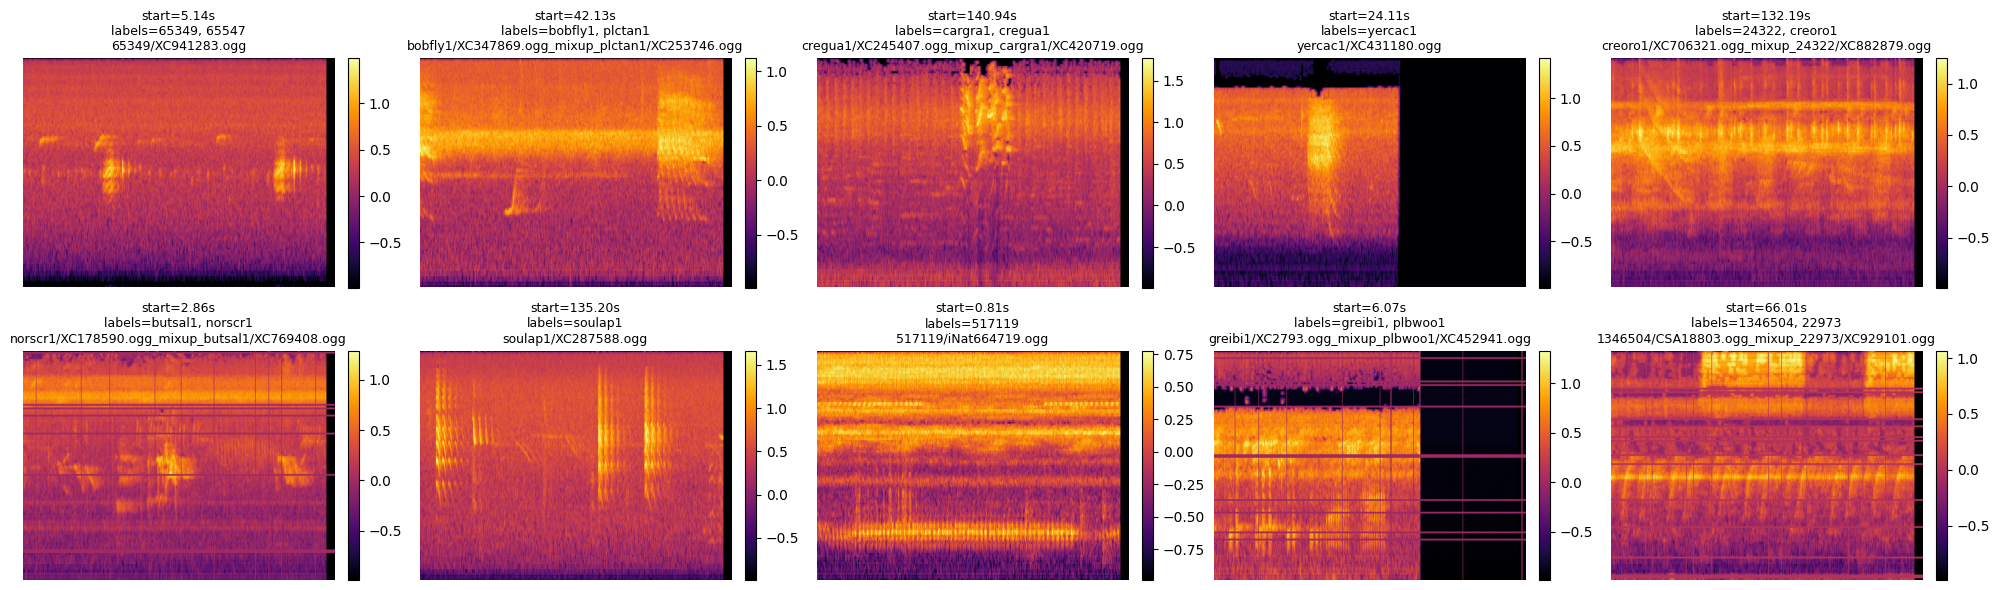

In [17]:
# How many samples to show
num_to_plot = 10
ncols = 5

for batch_idx, (spec_batch, label_batch, filename_batch, start_times) in enumerate(train_loader):
    batch_size = len(filename_batch)
    num_plot = min(batch_size, num_to_plot)
    nrows = int(np.ceil(num_plot / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))

    for idx in range(num_plot):
        spec = spec_batch[idx].cpu().numpy()   # (time, mel_bins)
        # If model features are (C, T, F) or (T, F, C), squeeze/transpose to (T, F)
        if spec.ndim == 3 and spec.shape[0] == 1:  # (1, T, F)
            spec = spec[0]
        elif spec.ndim == 3 and spec.shape[-1] == 1:  # (T, F, 1)
            spec = spec[..., 0]

        ax = axes.flat[idx] if nrows > 1 or ncols > 1 else axes
        im = ax.imshow(spec.T, origin='lower', aspect='auto', cmap='inferno')

        # Decode hard labels for title
        pos_indices = torch.where(label_batch[idx] > 0)[0].cpu().numpy()
        decoded_labels = birdnet_data.label_encoder.inverse_transform(pos_indices)

        title = (
            f"start={start_times[idx]:.2f}s\n"
            f"labels={', '.join(decoded_labels) if len(decoded_labels)>0 else '-'}\n"
            f"{filename_batch[idx]}"
        )
        ax.set_title(title, fontsize=9)
        ax.axis('off')

        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide remaining empty subplots
    for idx in range(num_plot, nrows * ncols):
        axes.flat[idx].axis('off')

    plt.tight_layout()
    plt.show()
    break  # only first batch


In [15]:
birdnet_data = RetreiveData(df.set_index('filename'))
for i in range(32):
    fname, labels, soft_labels, start_time, file_kind = birdnet_data.get_file_and_start_time(training_filenames[i][0],training_filenames[i][1],get_ahead=False)
    print(f'Filename: {fname}, Start Time: {start_time}, Labels: {labels}, Soft Labels: {soft_labels}, File Kind: {file_kind}')
    print(type(labels))

Removed 12 rows.
Filename: crcwoo1/XC525489.ogg, Start Time: 63.0, Labels: ['crcwoo1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: 67082/iNat221222.ogg, Start Time: 0.0, Labels: ['67082'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: soulap1/XC506875.ogg, Start Time: 21.0, Labels: ['soulap1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: whtdov/XC409342.ogg, Start Time: 63.0, Labels: ['cinbec1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: anhing/XC657828.ogg, Start Time: 9.0, Labels: ['anhing'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: 528041/CSA36359.ogg, Start Time: 49.0, Labels: ['528041'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: 566513/iNat879932.ogg, Start Time: 52.0, Labels: ['566513'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: ruther1/XC243694.ogg, Start Time: 24.0, Labels: ['compau', 'ruther1'], Soft Labels: [1, 1], F

# **Masked Auto Encoder Model**
## Bird-MAE Fine-Tuning and Training Loop

This cell initializes, configures, and trains a Bird-MAE–based classifier for multi‑label bird audio classification, including feature extraction, loss functions, optimizer setup, and a full training/validation loop.

### Key Components



1. **Model Architecture (`BirdMAEForClassification`)**
   - Wraps a pretrained Bird-MAE encoder (`DBD-research-group/Bird-MAE-Base`) with a custom MLP classifier head.
   - Classifier: Dropout → Linear → GELU → Dropout → Linear → GELU → Dropout → Final Linear.
   - Weights initialized with Xavier uniform.

2. **Loss Functions**
   - `AsymmetricLoss`: Focal-like loss that down-weights easy negatives and focuses gradient on hard positives/negatives (configurable `gamma_pos`, `gamma_neg`, `clip`).
   - Early runs used `AsymmetricLoss` with `gamma_pos=0` and `gamma_neg=4` with `clip=0.05`. Later runs used `gamma_pos=0` and `gamma_neg=5` with `clip=0.05`

4. **Optimizer & Learning Rate Scheduling**
  - Using the `AdamW` optimizer with **layer‑wise learning rates**:
    - **Encoder:** `1e-5` (lower for stability) — originally experimented with higher rates (`5e-5`, `4e-5`, `2e-5`) in earlier runs.
    - **Classifier:** `5e-4` — originally higher (`1e-3`, `9e-4`, `7e-4`) in earlier runs.
  - In early experiments, the higher learning rates helped the model adapt quickly but led to less stable convergence.
  - Gradually lowering both encoder and classifier learning rates in later runs improved stability, calibration, and ultimately validation F1.
  - **Weight decay:** `0.01` on both parameter groups.
  - **Scheduler:** `CosineAnnealingLR` with `T_max=10` and `eta_min=1e-6` — decays the learning rate each epoch on a fixed cosine curve, regardless of validation performance.


4. **Training Loop**
   - Supports **gradient accumulation** (`gradient_accumulation_steps=16`) to simulate larger batch sizes.
   - Applies feature extraction per batch using Bird-MAE’s `AutoFeatureExtractor`.
   - Forward pass → compute loss → backpropagate → optimizer step (with gradient clipping).
   - Saves model checkpoint periodically every 300 batches.

5. **Metrics Monitoring**
   - Computes precision, recall, and F1 score at the **sample level** with `average='samples'`.
   - Tracks positive prediction counts, label sparsity, and raw logits stats for diagnostic.
   - Stores and aggregates all predictions/labels for epoch‑level metric calculation.

6. **Validation Loop**
   - Runs model in eval mode, collects validation predictions and metrics.
   - Saves best model checkpoint when validation F1 improves over `best_val_f1`.
   - Updates LR scheduler at the end of each validation epoch.

### Notes
- **Current LR schedule does not depend on improvement** — `CosineAnnealingLR` lowers LR each epoch on a fixed curve.
- The architecture and loss are tuned for **multi‑label classification of bird calls** from both `train_audio` and `train_soundscapes`.
- Frequently training was stopped after 1 or 2 epochs to regenerate the training data.  Roughly 10000 files were passed at a time running 1 to 2 epochs before passing in new data.
- Interestingly specAug seemed to hinder model performance.

In [14]:
# ----------------- Improved Model Definition -----------------
class BirdMAEForClassification(nn.Module):
    def __init__(self, encoder, num_labels, hidden_dim=512, pooling_strategy='mean'):
        super().__init__()
        self.encoder = encoder
        self.pooling_strategy = pooling_strategy

        # Get the actual embedding dimension from the encoder
        embed_dim = encoder.config.embed_dim  # This is 768 from your config

        print(f"Creating classifier with embed_dim: {embed_dim}")

        # Create the MLP classifier head immediately
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_dim // 2, num_labels)
        )

        # Initialize classifier weights properly
        self._init_classifier_weights()

    def _init_classifier_weights(self):
        """Initialize classifier weights with proper scaling"""
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, pixel_values=None):
        outputs = self.encoder(pixel_values, return_dict=True)

        # Get the last hidden state - Bird-MAE already does global pooling
        embeddings = outputs.last_hidden_state  # Shape: [batch_size, embed_dim]

        # Pass through classifier (no pooling needed since it's already done)
        logits = self.classifier(embeddings)

        return logits

# ----------------- Loss Functions (Keep your existing ones) -----------------
class BalancedBinaryLoss(nn.Module):
    def __init__(self, weight_pos=0.49, weight_neg=0.51, epsilon=1e-7):
        super(BalancedBinaryLoss, self).__init__()
        self.weight_pos = weight_pos
        self.weight_neg = weight_neg
        self.epsilon = epsilon

    def forward(self, preds, targets):
        preds_sigmoid = torch.sigmoid(preds)
        preds_clamped = torch.clamp(preds_sigmoid, self.epsilon, 1 - self.epsilon)
        bce = F.binary_cross_entropy(preds_clamped, targets, reduction='none')

        pos_mask = (targets == 1).float()
        neg_mask = (targets == 0).float()

        pos_loss = (bce * pos_mask).sum(dim=1) / (pos_mask.sum(dim=1) + self.epsilon)
        neg_loss = (bce * neg_mask).sum(dim=1) / (neg_mask.sum(dim=1) + self.epsilon)

        balanced_loss = self.weight_pos * pos_loss + self.weight_neg * neg_loss
        return balanced_loss.mean()

class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_pos=0, gamma_neg=4, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.clip = clip
        self.eps = eps

    def forward(self, preds, targets):
        preds_sigmoid = torch.sigmoid(preds)
        preds_pos = preds_sigmoid
        preds_neg = 1 - preds_sigmoid

        if self.clip is not None and self.clip > 0:
            preds_neg = (preds_neg + self.clip).clamp(max=1)

        loss_pos = targets * torch.log(preds_pos.clamp(min=self.eps))
        loss_neg = (1 - targets) * torch.log(preds_neg.clamp(min=self.eps))

        loss_pos *= (1 - preds_pos).pow(self.gamma_pos)
        loss_neg *= (preds_pos).pow(self.gamma_neg)

        loss = - (loss_pos + loss_neg).mean()
        return loss

# Helper functions for metrics
def logits_to_preds(logits, threshold=0.5):
    probs = torch.sigmoid(logits)
    return (probs > threshold).cpu().numpy().astype(int)

def soft_labels_to_hard_labels(labels_tensor, threshold=0.5):
    return (labels_tensor > threshold).numpy().astype(int)

# Define the MAE directory inside models_dir
mae_dir = os.path.join(models_dir, 'MAE')
os.makedirs(mae_dir, exist_ok=True)

# ----------------- Improved Model Initialization -----------------
encoder = AutoModel.from_pretrained("DBD-research-group/Bird-MAE-Base", trust_remote_code=True)
feature_extractor = AutoFeatureExtractor.from_pretrained("DBD-research-group/Bird-MAE-Base", trust_remote_code=True)

# Debug: Print encoder configuration
print("Encoder config attributes:")
for attr in dir(encoder.config):
    if not attr.startswith('_') and not callable(getattr(encoder.config, attr)):
        try:
            value = getattr(encoder.config, attr)
            print(f"  {attr}: {value}")
        except:
            print(f"  {attr}: <error accessing>")
best_val_f1=0.9115 # 0.8797 #0.8723 #0.8686#0.8567#0.8503 #0.8388#0.8332#0.8237 #0.7908 #0.7877
num_labels = 206
model = BirdMAEForClassification(encoder, num_labels, hidden_dim=512, pooling_strategy='mean')
# 2. Load the state dictionary
# Note checkpoint 26 is the last checkpoint before added data
checkpoint_num=27
model_path =  os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_mixup_full_val_{checkpoint_num}.pt')

model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Choose your loss function
criterion = AsymmetricLoss(gamma_pos=0, gamma_neg=5, clip=0.05)

# ----------------- Improved Optimizer Configuration -----------------
# Better learning rates with layer-wise decay
optimizer_parameters = [
    # Encoder layers with lower learning rate
    {'params': model.encoder.parameters(), 'lr': 1e-5, 'weight_decay': 0.01}, # original: 5e-5,4e-5,2e-5
    # Classifier with higher learning rate
    {'params': model.classifier.parameters(), 'lr': 5e-4, 'weight_decay': 0.01} # original: 1e-3,9e-4, 7e-4
]
optimizer = optim.AdamW(optimizer_parameters, betas=(0.9, 0.999), eps=1e-8)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

#optimal_class_thresholds=np.load(os.path.join(supplemental_files_dir,'optimal_class_thresholds_dict.npy'),allow_pickle='TRUE').item()

optimal_class_thresholds=np.load(os.path.join(supplemental_files_dir,'updated_class_thresholds.npy'),allow_pickle='TRUE').item()
all_classes = birdnet_data.label_encoder.classes_  # or wherever you store label encoder

thresholds_array = np.array([optimal_class_thresholds.get(cls, 0.5) for cls in all_classes])  # fallback to 0.5



num_epochs = 6
gradient_accumulation_steps = 16
run_train=False
if run_train:
  # ----------------- Improved Training Loop -----------------
  for epoch in range(num_epochs):
      train_dataset.on_epoch_end()
      # --- Training Loop ---
      model.train()
      running_loss = 0.0
      all_preds = []
      all_targets = []
      optimizer.zero_grad()

      print(f"\nEpoch {epoch+1}/{num_epochs}")
      print("-" * 50)

      for batch_idx, (inputs, label_batch, _,_) in enumerate(train_loader, 1):
          try:
              # Handle different possible return formats from feature extractor
              if isinstance(inputs, dict):
                  pixel_values = inputs['input_values'].to(device)
              else:
                  pixel_values = inputs.to(device)

              # Ensure correct shape: if 3D, add channel dimension
              if len(pixel_values.shape) == 3:
                  pixel_values = pixel_values.unsqueeze(1)

              labels = label_batch.to(device)

              # Forward pass
              outputs = model(pixel_values=pixel_values)
              loss = criterion(outputs, labels) / gradient_accumulation_steps
              loss.backward()

              # Gradient accumulation
              if (batch_idx % gradient_accumulation_steps == 0) or (batch_idx == len(train_loader)):
                  # Gradient clipping to prevent exploding gradients
                  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                  optimizer.step()
                  optimizer.zero_grad()

              running_loss += loss.item() * gradient_accumulation_steps

              # Calculate batch metrics
              batch_preds = logits_to_preds(outputs, threshold=0.5)
              batch_targets = soft_labels_to_hard_labels(labels.cpu(), threshold=0.5)

              all_preds.append(batch_preds)
              all_targets.append(batch_targets)

              # Calculate and display metrics every 20 batches to monitor learning
              if batch_idx % 20 == 0:
                  precision = precision_score(batch_targets, batch_preds, average='samples', zero_division=0)
                  recall = recall_score(batch_targets, batch_preds, average='samples', zero_division=0)
                  f1 = f1_score(batch_targets, batch_preds, average='samples', zero_division=0)
                  current_lr = optimizer.param_groups[0]['lr']

                  # Calculate diagnostic metrics to understand what's happening
                  avg_predictions_per_sample = batch_preds.sum(axis=1).mean()
                  avg_labels_per_sample = batch_targets.sum(axis=1).mean()
                  prediction_sparsity = (batch_preds == 0).mean()

                  # Check if model is just predicting everything as positive/negative
                  total_positive_preds = batch_preds.sum()
                  total_positive_labels = batch_targets.sum()
                  total_predictions = batch_preds.size

                  # Look at the raw logits to see if they're reasonable
                  with torch.no_grad():
                      logits_stats = {
                          'min': outputs.min().item(),
                          'max': outputs.max().item(),
                          'mean': outputs.mean().item(),
                          'std': outputs.std().item()
                      }

                  print(f"Batch [{batch_idx:3d}/{len(train_loader)}] "
                        f"Loss: {loss.item() * gradient_accumulation_steps:.4f} "
                        f"P: {precision:.3f} R: {recall:.3f} F1: {f1:.3f} "
                        f"| Pred+: {total_positive_preds}/{total_predictions} "
                        f"Label+: {total_positive_labels} "
                        f"| Logits: μ={logits_stats['mean']:.2f} σ={logits_stats['std']:.2f} "
                        f"range=[{logits_stats['min']:.2f}, {logits_stats['max']:.2f}]")
              if batch_idx % 300 == 0:
                # Assuming 'model' is your trained BirdMAEForClassification instance
                model_path = os.path.join(drive_dir,'bird_mae_classifier_mixup.pt')

                # Save only the model's state dictionary
                torch.save(model.state_dict(), model_path)
                print(f"Model saved to {model_path}")
          except Exception as e:
              print(f"Error in batch {batch_idx}: {str(e)}")
              continue

      # Epoch training summary
      if all_preds and all_targets:
          all_preds_epoch = np.vstack(all_preds)
          all_targets_epoch = np.vstack(all_targets)
          epoch_precision = precision_score(all_targets_epoch, all_preds_epoch, average='samples', zero_division=0)
          epoch_recall = recall_score(all_targets_epoch, all_preds_epoch, average='samples', zero_division=0)
          epoch_f1 = f1_score(all_targets_epoch, all_preds_epoch, average='samples', zero_division=0)
          avg_train_loss = running_loss / max(1, len(train_loader) // gradient_accumulation_steps)

          print(f"\nTraining Summary - Epoch {epoch+1}: "
                f"Loss: {avg_train_loss:.4f} Precision: {epoch_precision:.4f} "
                f"Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}")

      # --- Validation Loop ---
      model.eval()
      val_running_loss = 0.0
      val_preds = []
      val_targets = []

      with torch.no_grad():
          for batch_idx, (inputs, label_batch, _,_) in enumerate(val_loader, 1):
              try:
                  # Handle different return formats
                  if isinstance(inputs, dict):
                      pixel_values = inputs['input_values'].to(device)
                  else:
                      pixel_values = inputs.to(device)

                  # Ensure correct shape
                  if len(pixel_values.shape) == 3:
                      pixel_values = pixel_values.unsqueeze(1)

                  labels = label_batch.to(device)

                  # Forward pass
                  outputs = model(pixel_values=pixel_values)
                  loss = criterion(outputs, labels)
                  val_running_loss += loss.item()

                  # Collect predictions and targets
                  batch_preds = logits_to_preds(outputs, threshold=0.5)
                  batch_targets = soft_labels_to_hard_labels(labels.cpu(), threshold=0.5)

                  val_preds.append(batch_preds)
                  val_targets.append(batch_targets)

              except Exception as e:
                  print(f"Error in validation batch {batch_idx}: {str(e)}")
                  continue

      # Validation summary
      if val_preds and val_targets:
          val_preds_epoch = np.vstack(val_preds)
          val_targets_epoch = np.vstack(val_targets)
          val_precision = precision_score(val_targets_epoch, val_preds_epoch, average='samples', zero_division=0)
          val_recall = recall_score(val_targets_epoch, val_preds_epoch, average='samples', zero_division=0)
          val_f1 = f1_score(val_targets_epoch, val_preds_epoch, average='samples', zero_division=0)
          avg_val_loss = val_running_loss / len(val_loader)

          print(f"Validation Summary - Epoch {epoch+1}: "
                f"Loss: {avg_val_loss:.4f} Precision: {val_precision:.4f} "
                f"Recall: {val_recall:.4f} F1: {val_f1:.4f}")
          if val_f1>best_val_f1:
            best_val_f1=val_f1
            model_path = os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_mixup_full_val_{checkpoint_num+1}.pt')
            torch.save(model.state_dict(), model_path)
            checkpoint_num+=1
            print(f"Model saved to {model_path}")
          # Update learning rate scheduler
          scheduler.step()

      print("=" * 50)
  runtime.unassign()
else:
  model.eval()
  test_preds = []
  test_targets = []
  test_probs_list = []

  with torch.no_grad():
      for batch_idx, (inputs, label_batch, _, _) in enumerate(test_loader, 1):
          if isinstance(inputs, dict):
              pixel_values = inputs['input_values'].to(device)
          else:
              pixel_values = inputs.to(device)

          if len(pixel_values.shape) == 3:
              pixel_values = pixel_values.unsqueeze(1)

          labels = label_batch.to(device)

          outputs = model(pixel_values=pixel_values)  # logits
          probs = torch.sigmoid(outputs).cpu().numpy()

          test_probs_list.append(probs)
          test_targets.append(labels.cpu().numpy())

          #batch_preds = (probs >= 0.55).astype(int)
          batch_preds = (probs >= thresholds_array).astype(int)
          test_preds.append(batch_preds)

  # Aggregate all predictions and targets
  test_preds = np.vstack(test_preds)
  test_targets = np.vstack(test_targets)
  test_probs = np.vstack(test_probs_list)

  # Calculate F1 scores as before
  f1_micro = f1_score(test_targets, test_preds, average='micro', zero_division=0)
  f1_samples = f1_score(test_targets, test_preds, average='samples', zero_division=0)

  # Compute macro-averaged ROC-AUC, skipping classes with no positive samples
  auc_scores = []
  for class_idx in range(test_targets.shape[1]):
      y_true = test_targets[:, class_idx]
      y_score = test_probs[:, class_idx]
      # Skip classes with no positive samples
      if np.sum(y_true) > 0 and np.sum(y_true) < len(y_true):
          auc = roc_auc_score(y_true, y_score)
          auc_scores.append(auc)

  macro_roc_auc = np.mean(auc_scores) if auc_scores else float('nan')
  print()
  print(f"Test F1 Scores: samples={f1_samples:.4f}, micro={f1_micro:.4f}")
  print(f"Macro ROC-AUC (BirdCLEF metric): {macro_roc_auc:.4f}")
#runtime.unassign()


config.json:   0%|          | 0.00/836 [00:00<?, ?B/s]

configuration_bird_mae.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/DBD-research-group/Bird-MAE-Base:
- configuration_bird_mae.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bird_mae.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/DBD-research-group/Bird-MAE-Base:
- modeling_bird_mae.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/342M [00:00<?, ?B/s]

Encoder config attributes:
  add_cross_attention: False
  architectures: ['BirdMAEModel']
  attn_drop_rate: 0.0
  attribute_map: {}
  auto_map: {'AutoConfig': 'configuration_bird_mae.BirdMAEConfig', 'AutoModel': 'modeling_bird_mae.BirdMAEModel', 'AutoModelForSequenceClassification': 'modeling_bird_mae.BirdMAEForSequenceClassification'}
  bad_words_ids: None
  base_config_key: 
  base_model_pp_plan: None
  base_model_tp_plan: None
  begin_suppress_tokens: None
  bos_token_id: None
  chunk_size_feed_forward: 0
  cross_attention_hidden_size: None
  decoder_start_token_id: None
  depth: 12
  diversity_penalty: 0.0
  do_sample: False
  drop_path_rate: 0.0
  drop_rate: 0.0
  early_stopping: False
  embed_dim: 768
  encoder_no_repeat_ngram_size: 0
  eos_token_id: None
  exponential_decay_length_penalty: None
  finetuning_task: None
  forced_bos_token_id: None
  forced_eos_token_id: None
  global_pool: mean
  has_no_defaults_at_init: False
  id2label: {0: 'LABEL_0', 1: 'LABEL_1'}
  img_size_x:

# **Save list of struggling classses based on test set f1 scores.**

In [16]:
rerun=False
save_struggling=False
if rerun:
  # Assuming test_targets and test_preds are numpy arrays with shape (num_samples, num_classes)
  f1_per_class = f1_score(test_targets, test_preds, average=None, zero_division=0)

  # Print out the F1 score per class alongside class names if you have them
  for idx, f1_val in enumerate(f1_per_class):
      class_name = birdnet_data.label_encoder.classes_[idx]  # adjust if your class names are elsewhere
      print(f"Class: {class_name}, F1 Score: {f1_val:.4f}")

  # Optionally, identify classes with lowest performance
  threshold = 0.5  # example threshold for “struggling” classes
  struggling_classes = [(birdnet_data.label_encoder.classes_[i], score)
                      for i, score in enumerate(f1_per_class) if score < threshold]

  print("\nClasses with F1 below threshold:")
  for cls, score in struggling_classes:
      print(f"{cls}: {score:.4f}")
  if save_struggling:
    np.save(os.path.join(supplemental_files_dir,'struggling_classes.npy'),struggling_classes)
else:
  struggling_classes=np.load(os.path.join(supplemental_files_dir,'struggling_classes.npy'),allow_pickle=True)
  print(f" Stuggling classes: {[str(f[0]) for f in struggling_classes]}")

 Stuggling classes: ['1139490', '1192948', '126247', '1462711', '1462737', '21116', '41778', '41970', '42007', '42087', '42113', '46010', '47067', '476538', '48124', '65336', '65547', '66531', '66578', '67082', '81930', 'ampkin1', 'blctit1', 'blkvul', 'grysee1', 'norscr1', 'piwtyr1', 'plukit1', 'rubsee1', 'ruther1', 'sahpar1', 'savhaw1', 'spbwoo1', 'thbeup1', 'turvul', 'whmtyr1', 'yelori1']


# **Test on Unseen Soundscapes**

In [17]:
num_labels = 206
model = BirdMAEForClassification(encoder, num_labels, hidden_dim=512, pooling_strategy='mean')
# 2. Load the state dictionary
# Note checkpoint 26 is the last checkpoint before added data
checkpoint_num=27
model_path =  os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_mixup_full_val_{checkpoint_num}.pt')

model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

soundscape_data=birdnet_data.data[birdnet_data.data['is_soundscape']]
soundscape_data=soundscape_data[soundscape_data['filename'].isin(validation_testing_soundscapes)]
soundscape_data['augment_flag']=False
soundscape_filenames=soundscape_data[['filename','start_time','augment_flag','primary_label']].values.tolist()
random.shuffle(soundscape_filenames)

num_labels = 206
soundscape_dataset = BirdAudioDataset(
    soundscape_filenames,
    birdnet_data,
    num_classes=206,
    feature_extractor=feature_extractor,
    sr=32000,
    mixup_prob=0.0  # Disable mixup for validation
)
# Create DataLoader for test dataset
soundscape_loader = DataLoader(
    soundscape_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0  # Adjust based on your system
)

model.eval()
test_preds = []
test_targets_soft = []
test_probs_list = []  # to collect probabilities

with torch.no_grad():
    for batch_idx, (inputs, label_batch, filenames, start_times) in enumerate(soundscape_loader, 1):
        if isinstance(inputs, dict):
            pixel_values = inputs['input_values'].to(device)
        else:
            pixel_values = inputs.to(device)

        if len(pixel_values.shape) == 3:
            pixel_values = pixel_values.unsqueeze(1)

        labels_soft = label_batch.to(device)

        outputs = model(pixel_values=pixel_values)  # logits

        probs = torch.sigmoid(outputs).cpu().numpy()
        test_probs_list.append(probs)
        test_targets_soft.append(labels_soft.cpu().numpy())

        #batch_preds = (probs >= 0.50).astype(int)  # threshold as you specified
        batch_preds = (probs >= thresholds_array).astype(int)
        test_preds.append(batch_preds)

# Aggregate all
test_preds = np.vstack(test_preds)
test_targets_soft = np.vstack(test_targets_soft)
test_probs = np.vstack(test_probs_list)

# Convert soft labels to hard labels for F1 calculations
test_targets_hard = (test_targets_soft >= 0.5).astype(int)

# Calculate F1 scores
f1_micro = f1_score(test_targets_hard, test_preds, average='micro', zero_division=0)
f1_samples = f1_score(test_targets_hard, test_preds, average='samples', zero_division=0)

# Calculate macro ROC-AUC, skipping classes with no positives
auc_scores = []
for class_idx in range(test_targets_hard.shape[1]):
    y_true = test_targets_hard[:, class_idx]
    y_score = test_probs[:, class_idx]
    if np.sum(y_true) > 0 and np.sum(y_true) < len(y_true):  # only classes with both pos/neg
        auc_scores.append(roc_auc_score(y_true, y_score))
macro_roc_auc = np.mean(auc_scores) if auc_scores else float('nan')

print(f"Test F1 Scores: samples={f1_samples:.4f}, micro={f1_micro:.4f}")
print(f"Macro ROC-AUC (BirdCLEF metric): {macro_roc_auc:.4f}")



Creating classifier with embed_dim: 768
Test F1 Scores: samples=0.8351, micro=0.8417
Macro ROC-AUC (BirdCLEF metric): 0.9769


In [71]:
def decode_labels(label_array, class_names):
    return [[class_names[i] for i, val in enumerate(sample) if val == 1] for sample in label_array]

class_names = birdnet_data.label_encoder.classes_
decoded_preds = decode_labels(test_preds, class_names)
decoded_targets = decode_labels(test_targets_hard, class_names)

# Create dataframe with filename, predicted labels, and true labels
soundscape_results_df = pd.DataFrame({
    'filename': [f[0] for f in soundscape_filenames],
    'start_time': [f[1] for f in soundscape_filenames],
    'predicted_labels': decoded_preds,
    'true_labels': decoded_targets
})

soundscape_results_df.sample(20,random_state=42)

,filename,start_time,predicted_labels,true_labels
2210,H90_20230509_144000.ogg,54.000000,[gycwor1],[gycwor1]
279,H04_20230502_174500.ogg,0.000000,[tbsfin1],[tbsfin1]
1490,H32_20230423_144500.ogg,42.000000,[crebob1],[crebob1]
3321,H10_20230513_211500.ogg,8.840507,[22976],"[22976, 65373, compau]"
2196,H20_20230428_000000.ogg,55.000000,[65373],[65373]
937,H98_20230425_100000.ogg,42.000000,[orcpar],[orcpar]
1651,H26_20230521_202000.ogg,0.000000,"[22976, compau]","[22976, bkcdon, compau]"
1391,H07_20230502_090000.ogg,45.000000,[rugdov],[rugdov]
478,H90_20230509_040000.ogg,0.000000,[speowl1],[speowl1]
1345,H79_20230517_104500.ogg,18.000000,[rugdov],[rugdov]


Plot of Soundscape file


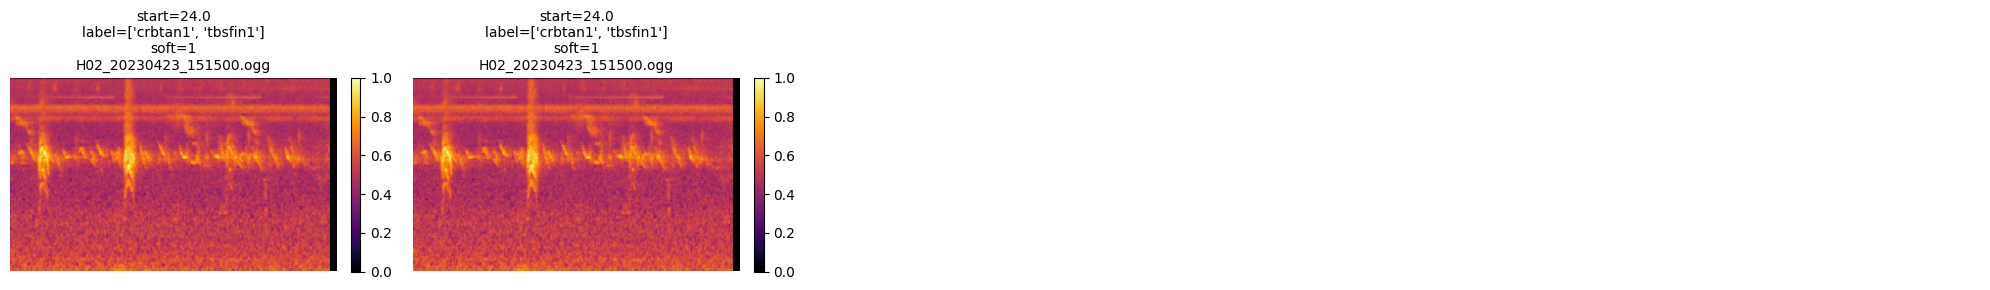

Examples of train_audio samples for True Labels....


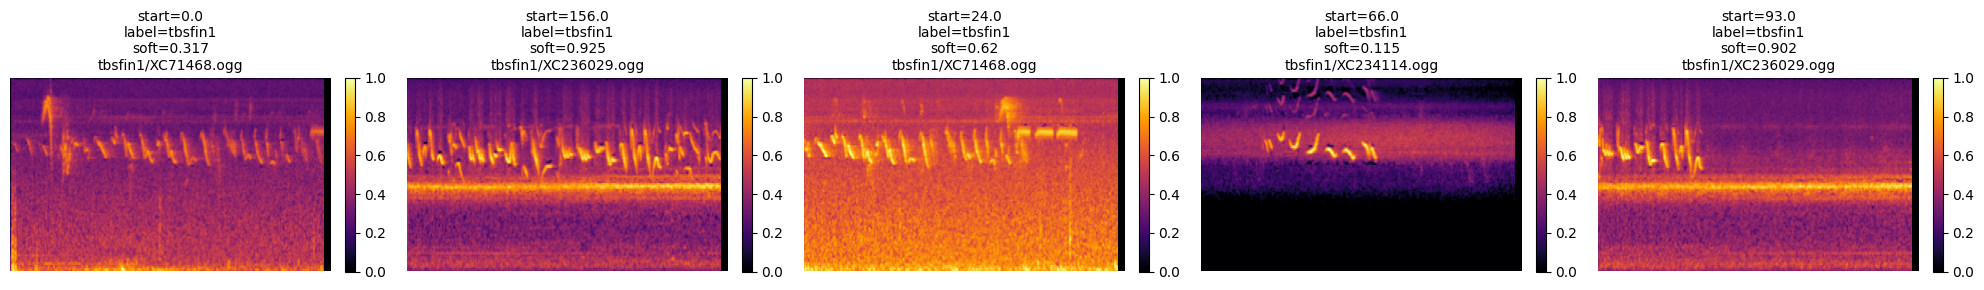

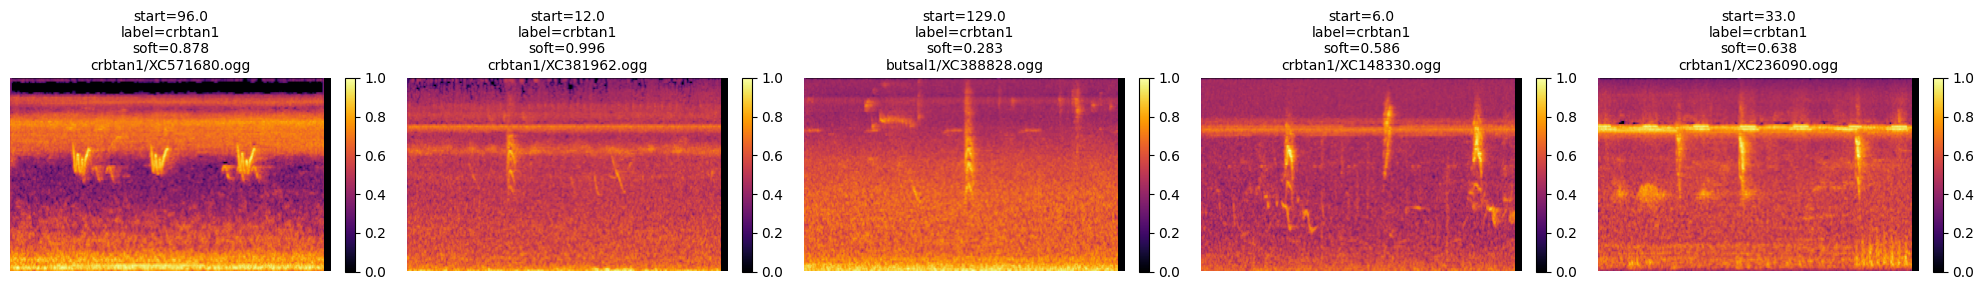

All predicted labels are already in the list of true labels.


In [79]:
def plot_spectrograms_grid(spectrograms, fnames, start_times, label_names, label_values, ncols=5):
    """
    Plot spectrograms in a grid of subplots with informative titles.
    """
    n = len(spectrograms)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))

    for idx, (spec, fname, stime, label, soft) in enumerate(zip(spectrograms, fnames, start_times, label_names, label_values)):
        ax = axes.flat[idx]
        # Plot only one channel (they are identical for color in EfficientNet)
        im = ax.imshow(spec[:, :, 0].T, origin='lower', aspect='auto', cmap='inferno')
        # Set the title containing all desired info
        title = (
            f"start={stime}\n"
            f"label={label}\n"
            f"soft={np.round(soft, 3)}\n"
            f"{fname}"
        )
        ax.set_title(title, fontsize=10)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide unused axes if less than nrows * ncols
    for idx in range(n, nrows * ncols):
        axes.flat[idx].axis('off')

    plt.tight_layout()
    plt.show()
def pad_or_truncate(mel_spec, target_length):
    if mel_spec.shape[0] > target_length:
        return mel_spec[:target_length, :]
    elif mel_spec.shape[0] < target_length:
        pad_width = target_length - mel_spec.shape[0]
        return np.pad(mel_spec, ((0, pad_width), (0, 0)), mode='constant')
    else:
        return mel_spec
def _normalize(audio):
        """Normalizes the audio waveform to the range [-1, 1] based on its peak."""
        peak = np.abs(audio).max()
        if peak > 0:
            return audio / peak
        return audio

def extract_spectrograms(file_list, start_times, sr=32000, segment_duration=5.0, target_time_length_spectrogram=320,normalize=True,audio_dir='train_soundscapes'):
    """
    Extract mel spectrograms from audio files starting at given times,
    each segment exactly segment_duration seconds long (padded if shorter).

    Args:
      file_list (list of str): Paths to audio files.
      start_times (list of float): Start times (seconds) for each file segment.
      sr (int): Sampling rate for librosa.load.
      segment_duration (float): Duration (in seconds) of segment to extract.
      target_time_length_spectrogram (int): Number of mel-spectrogram frames to pad/truncate to.

    Returns:
      list of np.ndarray: List of 3-channel mel spectrogram arrays.
    """
    spectrograms = []
    for file_path, start_time in zip(file_list, start_times):
        f_path=os.path.join(main_dir,audio_dir,file_path)
        # Load the segment from file (exact segment_duration seconds, or shorter if not enough length)
        try:
          audio, _ = librosa.load(f_path, sr=sr, mono=True, offset=start_time, duration=segment_duration)
        except:
          continue
        if normalize:
          audio=_normalize(audio)
        # Extract mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T

        # Normalize to [0, 1]
        min_db, max_db = -80.0, 0.0
        mel_spec_scaled = np.clip((mel_spec_db - min_db) / (max_db - min_db), 0.0, 1.0)

        # Pad or truncate frames to fixed target length
        mel_spec_padded = pad_or_truncate(mel_spec_scaled, target_time_length_spectrogram)[:, :, np.newaxis]

        # Duplicate single channel to 3 channels for EfficientNet input
        mel_spec_padded_3_channel = np.repeat(mel_spec_padded, 3, axis=-1)

        spectrograms.append(mel_spec_padded_3_channel)
    return spectrograms
file_interested_in = 'H02_20230423_151500.ogg'
start_time = 24.0
print('Plot of Soundscape file')
# Filter the segment to plot and extract info
data_to_plot = soundscape_results_df[
    (soundscape_results_df['filename'] == file_interested_in) &
    (soundscape_results_df['start_time'] == start_time)
]
fnames = data_to_plot['filename'].values
start_times = data_to_plot['start_time'].values
specs = extract_spectrograms(fnames, start_times)
labs = data_to_plot['true_labels'].values
pred_labs = data_to_plot['predicted_labels'].values

# Only plot the soundscape segment ONCE
if len(specs) > 0:
    plot_spectrograms_grid(specs, fnames, start_times, labs, [1 for _ in range(len(labs))], ncols=5)
else:
    print("No spectrograms to plot for the soundscape segment.")
print('Examples of train_audio samples for True Labels....')
non_soundscape_data = birdnet_data.data[birdnet_data.data['is_soundscape'] == False]
all_labels = set(labs[0]) if len(labs) > 0 else set()

# Plot samples for each label in the list of true labels
for lab in all_labels:
    samples = non_soundscape_data[non_soundscape_data['primary_label'] == lab].sample(5)
    fnames = samples['filename'].values
    start_times = samples['start_time'].values
    conf = samples['confidence'].values
    primary_labels = samples['primary_label'].values

    specs = extract_spectrograms(fnames, start_times, audio_dir='train_audio')
    plot_spectrograms_grid(specs, fnames, start_times, primary_labels, conf, ncols=5)

# Plot samples for each predicted label that isn't an already plotted true label
if len(pred_labs) > 0:
    predicted_not_true = [lab for lab in pred_labs[0] if lab not in all_labels]
    if predicted_not_true:
        print("Now plotting predicted label grids (not in true_labels):", predicted_not_true)
        for lab in predicted_not_true:
            samples = non_soundscape_data[non_soundscape_data['primary_label'] == lab].sample(5)
            fnames = samples['filename'].values
            start_times = samples['start_time'].values
            conf = samples['confidence'].values
            primary_labels = samples['primary_label'].values

            specs = extract_spectrograms(fnames, start_times, audio_dir='train_audio')
            plot_spectrograms_grid(specs, fnames, start_times, primary_labels, conf, ncols=5)
    else:
        print("All predicted labels are already in the list of true labels.")
else:
    print("No predicted labels available for plotting.")


### **Comparison of Bird Audio Classification Models on Validation and Soundscape Data**

This code demonstrates how to evaluate different trained BirdMAE models on two separate datasets:  
1. The **validation set**, representing standard evaluation data.  
2. The **soundscape set**, a subset of audio data containing specialized environmental sound recordings.

---

#### Dataset and DataLoader Setup

- We construct a `soundscape_dataset` that filters for soundscape files from the BirdNet dataset based on predefined filenames.
- The dataset disables augmentation (`mixup_prob=0.0`) for clean evaluation.
- A `DataLoader` called `soundscape_loader` is created for batch loading with a batch size of 16 and 2 worker processes.

---

#### Models to Evaluate

Three models are evaluated, each representing different training regimes:

1. **Mixup + Negative Samples + SpecAug Model:**  
   Model trained with mixup augmentation, negative sampling, and spectrogram augmentation for robust generalization.

2. **Soundscapes-Augmented Model:**  
   Model trained with additional soundscape data included in training for improved environmental context.

3. **Train Audio Only Model:**  
   Baseline model trained solely on standard training audio without additional augmentation or data.

---

#### Evaluation Function

- Sets the model to evaluation mode.
- Iterates over batches of data from the provided loader.
- Handles different input formats from the feature extractor.
- Computes sigmoid probabilities on model outputs to generate predictions with a threshold of 0.55.
- Aggregates predictions, ground truth labels, and probabilities across batches.

---

#### Metrics Computed

- **Micro F1 Score:** Measures overall instance-level F1 across all classes, compensating for class imbalance.
- **Samples F1 Score:** Evaluates average F1 per sample to reflect multi-label prediction quality.
- **Macro ROC-AUC:** Computes average ROC-AUC across classes, skipping classes without positive samples to avoid bias.

---

#### Execution

Each model checkpoint is loaded sequentially and evaluated on both validation and soundscape datasets, printing out the associated metrics. This structure allows direct comparison of model performance gains due to progressive augmentation and data inclusion strategies.

---

This approach facilitates a clear understanding of how different training strategies impact performance on diverse evaluation sets, guiding future improvements in bird audio classification models.


In [83]:
import torch
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score

num_labels = 206

# Create soundscape_loader as you described
soundscape_data = birdnet_data.data[birdnet_data.data['is_soundscape']]
soundscape_data = soundscape_data[soundscape_data['filename'].isin(validation_testing_soundscapes)]
soundscape_data['augment_flag'] = False
soundscape_filenames = soundscape_data[['filename', 'start_time', 'augment_flag', 'primary_label']].values.tolist()
random.shuffle(soundscape_filenames)

soundscape_dataset = BirdAudioDataset(
    soundscape_filenames,
    birdnet_data,
    num_classes=num_labels,
    feature_extractor=feature_extractor,
    sr=32000,
    mixup_prob=0.0,
    apply_adjusted_st=False
)

soundscape_loader = DataLoader(
    soundscape_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

# Models to evaluate
models = [
    {'mixup_neg_samp_aug': 'bird_mae_classifier_checkpoint_mixup_full_val_27.pt'},
    {'best_with_add_train_soundscapes': 'bird_mae_classifier_checkpoint_21.pt'},
    {'before_train_soundscapes': 'bird_mae_classifier_checkpoint_9.pt'}
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels, _, _ = batch
            if isinstance(inputs, dict):
                pixel_values = inputs['input_values'].to(device)
            else:
                pixel_values = inputs.to(device)
            if pixel_values.dim() == 3:
                pixel_values = pixel_values.unsqueeze(1)
            labels = labels.to(device)
            outputs = model(pixel_values=pixel_values)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= thresholds_array).astype(int)
            all_preds.append(preds)
            all_targets.append(labels.cpu().numpy())
            all_probs.append(probs)
    preds = np.vstack(all_preds)
    targets = np.vstack(all_targets)
    probs = np.vstack(all_probs)
    targets_hard = (targets >= 0.5).astype(int)

    f1_micro = f1_score(targets_hard, preds, average='micro', zero_division=0)
    f1_samples = f1_score(targets_hard, preds, average='samples', zero_division=0)
    auc_scores = []
    for i in range(targets_hard.shape[1]):
        y_true = targets_hard[:, i]
        y_score = probs[:, i]
        if np.sum(y_true) > 0 and np.sum(y_true) < len(y_true):
            auc_scores.append(roc_auc_score(y_true, y_score))
    macro_roc_auc = np.mean(auc_scores) if auc_scores else float('nan')

    return f1_micro, f1_samples, macro_roc_auc

# Loop over models and evaluate
for model_info in models:
    for model_name, checkpoint_file in model_info.items():
        print(f"Evaluating {model_name} ({checkpoint_file}):")
        model = BirdMAEForClassification(encoder, num_labels, hidden_dim=512, pooling_strategy='mean')
        model_path = os.path.join(mae_dir, checkpoint_file)
        model.load_state_dict(torch.load(model_path))
        model.to(device)

        # Evaluate on validation loader
        val_micro_f1, val_samples_f1, val_macro_auc = evaluate_model(model, val_loader)
        print(f"  Validation set -> micro F1: {val_micro_f1:.4f}, samples F1: {val_samples_f1:.4f}, macro ROC-AUC: {val_macro_auc:.4f}")

        # Evaluate on soundscape loader
        sc_micro_f1, sc_samples_f1, sc_macro_auc = evaluate_model(model, soundscape_loader)
        print(f"  Soundscape set -> micro F1: {sc_micro_f1:.4f}, samples F1: {sc_samples_f1:.4f}, macro ROC-AUC: {sc_macro_auc:.4f}")
        print()


Evaluating mixup_neg_samp_aug (bird_mae_classifier_checkpoint_mixup_full_val_27.pt):
Creating classifier with embed_dim: 768
  Validation set -> micro F1: 0.9238, samples F1: 0.9203, macro ROC-AUC: 0.9947
  Soundscape set -> micro F1: 0.8421, samples F1: 0.8358, macro ROC-AUC: 0.9783

Evaluating best_with_add_train_soundscapes (bird_mae_classifier_checkpoint_21.pt):
Creating classifier with embed_dim: 768
  Validation set -> micro F1: 0.9188, samples F1: 0.9189, macro ROC-AUC: 0.9943
  Soundscape set -> micro F1: 0.8386, samples F1: 0.8428, macro ROC-AUC: 0.9724

Evaluating before_train_soundscapes (bird_mae_classifier_checkpoint_9.pt):
Creating classifier with embed_dim: 768
  Validation set -> micro F1: 0.8794, samples F1: 0.8626, macro ROC-AUC: 0.9678
  Soundscape set -> micro F1: 0.7470, samples F1: 0.7269, macro ROC-AUC: 0.9552



# **Compare models for files with secondary labels**

In [82]:
# Filter for rows where secondary_labels is not empty and not ['']
filtered_df = df[
    df['secondary_labels'].apply(lambda x: isinstance(x, list) and len(x) > 0 and x != [''])
]
val_filtered_df=filtered_df[filtered_df['filename'].isin(original_test_filenames+original_val_filenames)]

files_with_secondary=val_filtered_df['filename'].values
data_to_use=birdnet_data.data[birdnet_data.data['filename'].isin(files_with_secondary)]
data_to_use['augment_flag']=False
secondary_filenames=data_to_use[['filename','start_time','augment_flag','primary_label']].values.tolist()

secondary_dataset = BirdAudioDataset(
    secondary_filenames,
    birdnet_data,
    num_classes=num_labels,
    feature_extractor=feature_extractor,
    sr=32000,
    mixup_prob=0.0
)

secondary_loader = DataLoader(
    secondary_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 206

models = [
    {'mixup_neg_samp_aug': 'bird_mae_classifier_checkpoint_mixup_full_val_27.pt'},
    {'best_with_add_train_soundscapes': 'bird_mae_classifier_checkpoint_21.pt'},
    {'mixup_neg_samp_aug_before_data_add': 'bird_mae_classifier_checkpoint_mixup_full_val_26.pt'}
]

for model_info in models:
    for model_name, checkpoint_file in model_info.items():
        print(f"Evaluating {model_name} ({checkpoint_file}) on secondary labels filtered set:")
        model = BirdMAEForClassification(encoder, num_labels, hidden_dim=512, pooling_strategy='mean')
        model_path = os.path.join(mae_dir, checkpoint_file)
        model.load_state_dict(torch.load(model_path))
        model.to(device)

        micro_f1, samples_f1, macro_roc_auc = evaluate_model(model, secondary_loader)

        print(f"  Secondary labels filtered -> micro F1: {micro_f1:.4f}, samples F1: {samples_f1:.4f}, macro ROC-AUC: {macro_roc_auc:.4f}\n")



Evaluating mixup_neg_samp_aug (bird_mae_classifier_checkpoint_mixup_full_val_27.pt) on secondary labels filtered set:
Creating classifier with embed_dim: 768
  Secondary labels filtered -> micro F1: 0.8604, samples F1: 0.8643, macro ROC-AUC: 0.9819

Evaluating best_with_add_train_soundscapes (bird_mae_classifier_checkpoint_21.pt) on secondary labels filtered set:
Creating classifier with embed_dim: 768
  Secondary labels filtered -> micro F1: 0.8624, samples F1: 0.8736, macro ROC-AUC: 0.9789

Evaluating mixup_neg_samp_aug_before_data_add (bird_mae_classifier_checkpoint_mixup_full_val_26.pt) on secondary labels filtered set:
Creating classifier with embed_dim: 768
  Secondary labels filtered -> micro F1: 0.8630, samples F1: 0.8665, macro ROC-AUC: 0.9802



### **Finding Optimal Per-Class Thresholds for Bird Audio Classification**

This code identifies the best threshold for each class individually to maximize F1 score, improving multi-label classification performance by tuning decision boundaries per bird species.

---

#### Key Components:

- **`find_best_thresholds_per_class`**:  
  Iterates over a range of candidate thresholds (default 0.3 to 0.79 in 0.01 steps) for each class and selects the threshold that yields the highest F1 score, considering only classes with positive samples.

- **`collect_probs_and_targets`**:  
  Runs inference with the model over a dataloader collecting predicted probabilities and ground truth labels for all samples, preparing data for threshold optimization.

- Loads a pre-trained BirdMAE model checkpoint and evaluates it on the validation set to gather predictions.

---

#### Purpose:

By optimizing thresholds on a per-class basis, this approach aligns prediction sensitivity to the individual characteristics of each bird species, ultimately enhancing detection accuracy in complex and imbalanced multi-label audio data.


In [39]:
model = BirdMAEForClassification(encoder, num_labels, hidden_dim=512, pooling_strategy='mean')
# 2. Load the state dictionary
# Note checkpoint 26 is the last checkpoint before added data
checkpoint_num=27
model_path =  os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_mixup_full_val_{checkpoint_num}.pt')
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
val_preds = []
val_targets_soft = []
val_probs_list = []  # to collect probabilities

with torch.no_grad():
    for batch_idx, (inputs, label_batch, filenames, start_times) in enumerate(val_loader, 1):
        if isinstance(inputs, dict):
            pixel_values = inputs['input_values'].to(device)
        else:
            pixel_values = inputs.to(device)

        if len(pixel_values.shape) == 3:
            pixel_values = pixel_values.unsqueeze(1)

        labels_soft = label_batch.to(device)

        outputs = model(pixel_values=pixel_values)  # logits

        probs = torch.sigmoid(outputs).cpu().numpy()
        val_probs_list.append(probs)
        val_targets_soft.append(labels_soft.cpu().numpy())

        #batch_preds = (probs >= 0.50).astype(int)  # threshold as you specified
        batch_preds = (probs >= thresholds_array).astype(int)
        val_preds.append(batch_preds)

# Aggregate all
val_preds = np.vstack(val_preds)
val_targets_soft = np.vstack(val_targets_soft)
val_probs = np.vstack(val_probs_list)

# Convert soft labels to hard labels for F1 calculations
val_targets_hard = (val_targets_soft >= 0.5).astype(int)

# Calculate F1 scores
f1_micro = f1_score(val_targets_hard, val_preds, average='micro', zero_division=0)
f1_samples = f1_score(val_targets_hard, val_preds, average='samples', zero_division=0)

# Calculate macro ROC-AUC, skipping classes with no positives
auc_scores = []
for class_idx in range(val_targets_hard.shape[1]):
    y_true = val_targets_hard[:, class_idx]
    y_score = val_probs[:, class_idx]
    if np.sum(y_true) > 0 and np.sum(y_true) < len(y_true):  # only classes with both pos/neg
        auc_scores.append(roc_auc_score(y_true, y_score))
macro_roc_auc = np.mean(auc_scores) if auc_scores else float('nan')

print(f"Validation F1 Scores: samples={f1_samples:.4f}, micro={f1_micro:.4f}")
print(f"Macro ROC-AUC (BirdCLEF metric): {macro_roc_auc:.4f}")

Creating classifier with embed_dim: 768
Validation F1 Scores: samples=0.9153, micro=0.9179
Macro ROC-AUC (BirdCLEF metric): 0.9947


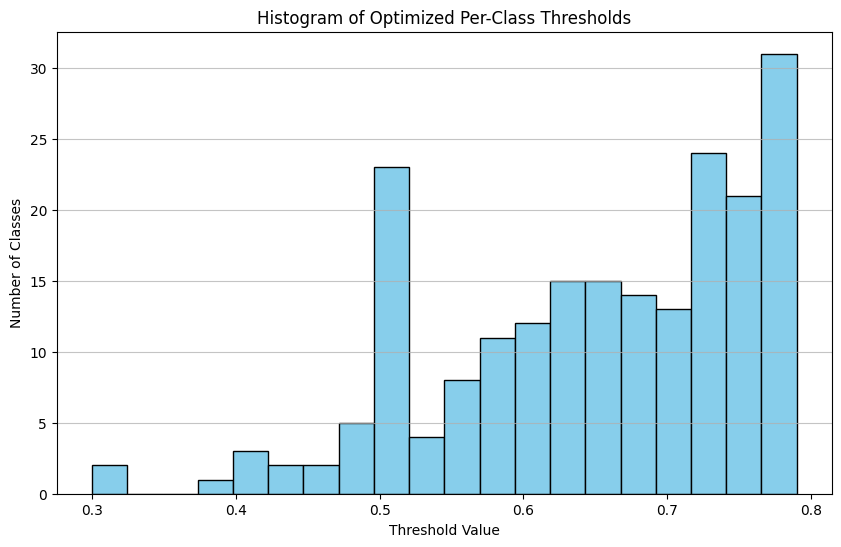

In [40]:
import numpy as np
from sklearn.metrics import f1_score

def find_best_thresholds_per_class(probs, targets, thresholds=np.arange(0.3, 0.8, 0.01)):
    """
    Find the best threshold per class to maximize F1 score.

    Args:
        probs: np.array of shape (num_samples, num_classes), predicted probabilities.
        targets: np.array of shape (num_samples, num_classes), ground truth binary labels.
        thresholds: iterable of threshold candidates to try.

    Returns:
        best_thresholds: np.array of shape (num_classes,), best threshold for each class.
    """
    num_classes = targets.shape[1]
    best_thresholds = np.zeros(num_classes)

    for i in range(num_classes):
        best_f1 = -1
        best_thresh = 0.5
        y_true = targets[:, i]
        y_prob = probs[:, i]

        for thresh in thresholds:
            y_pred = (y_prob >= thresh).astype(int)
            # Only compute if there is at least one positive label
            if y_true.sum() > 0:
                f1 = f1_score(y_true, y_pred, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_thresh = thresh

        best_thresholds[i] = best_thresh

    return best_thresholds
def collect_probs_and_targets(model, data_loader):
    model.eval()
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels, _, _ = batch
            if isinstance(inputs, dict):
                pixel_values = inputs['input_values'].to(device)
            else:
                pixel_values = inputs.to(device)
            if pixel_values.dim() == 3:
                pixel_values = pixel_values.unsqueeze(1)
            labels = labels.to(device)
            outputs = model(pixel_values=pixel_values)
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.append(probs)
            all_targets.append(labels.cpu().numpy())
    all_probs = np.vstack(all_probs)
    all_targets = np.vstack(all_targets)
    return all_probs, all_targets


probs, targets = val_probs, val_targets_hard
best_thresholds=find_best_thresholds_per_class(probs, targets)
class_threshold_mapping = {
    label: thresh
    for label, thresh in zip(birdnet_data.label_encoder.classes_, best_thresholds)
}

# Assuming best_thresholds is a numpy array of thresholds per class from your function
plt.figure(figsize=(10, 6))
plt.hist(best_thresholds, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Optimized Per-Class Thresholds")
plt.xlabel("Threshold Value")
plt.ylabel("Number of Classes")
plt.grid(axis='y', alpha=0.75)
plt.show()



save=False
if save:
  np.save(os.path.join(supplemental_files_dir,'optimal_class_thresholds_dict.npy'),class_threshold_mapping)


# **Get scores for validation set with optimal class thresholds**

In [51]:
def binarize_preds_with_thresholds(probs, class_threshold_mapping, classes, fallback=0.5):
    """
    Binarize predicted probabilities using per-class thresholds with fallback.

    Args:
        probs: np.array shape (N, C)
        class_threshold_mapping: dict {class_name: threshold}
        classes: list or array of class names of length C
        fallback: float, default threshold for classes not in mapping

    Returns:
        binarized_predictions: np.array shape (N, C)
    """
    thresholds = np.array([class_threshold_mapping.get(c, fallback) for c in classes])
    return (probs >= thresholds).astype(int)


classes = birdnet_data.label_encoder.classes_  # or equivalent

preds = binarize_preds_with_thresholds(probs, optimal_class_thresholds, classes)

# Now compute F1 scores
f1_micro = f1_score(targets, preds, average='micro', zero_division=0)
f1_samples = f1_score(targets, preds, average='samples', zero_division=0)
f1_per_class = f1_score(targets, preds, average=None, zero_division=0)
np.save(os.path.join(supplemental_files_dir,'updated_class_thresholds.npy'),class_threshold_mapping)
print(f"Micro F1: {f1_micro:.4f}")
print(f"Samples F1: {f1_samples:.4f}")

Micro F1: 0.9238
Samples F1: 0.9203


### Results DataFrame

In [45]:
# Decode predicted and true labels
decoded_preds = decode_labels(preds, classes)
decoded_targets = decode_labels(targets, classes)

# Create DataFrame
df_results = pd.DataFrame({
    'predicted_labels': decoded_preds,
    'true_labels': decoded_targets
})

# Optionally, add sample indices or filenames if you have them
# For example, if you have a list val_filenames aligned with preds/targets:
df_results['filename'] = [f[0] for f in validation_filenames]
df_results['start_time'] = [f[1] for f in validation_filenames]

df_results.sample(20)


,predicted_labels,true_labels,filename,start_time
6719,[chbant1],[chbant1],chbant1/XC437357.ogg,156.0
9142,[greani1],[greani1],greani1/XC341239.ogg,36.0
4242,[bkmtou1],[bkmtou1],bkmtou1/iNat373847.ogg,6.0
11974,[],[linwoo1],linwoo1/XC353289.ogg,138.0
12505,[orcpar],[orcpar],orcpar/XC331362.ogg,27.0
19869,"[bubwre1, whfant1]",[whfant1],whfant1/XC244935.ogg,9.0
8971,[gohman1],[gohman1],gohman1/iNat605185.ogg,15.0
4496,[blbgra1],[blbgra1],blbgra1/XC789226.ogg,9.0
13420,[],[purgal2],purgal2/XC143690.ogg,21.0
11964,[linwoo1],[linwoo1],linwoo1/XC344481.ogg,9.0


# **Look at files with secondary labels**
- Notably the largest struggle is identifying multiple species in the same clip.  Below we analyze files that have at least one secondary label.

In [84]:
model = BirdMAEForClassification(encoder, num_labels, hidden_dim=512, pooling_strategy='mean')
# 2. Load the state dictionary
# Note checkpoint 26 is the last checkpoint before added data
checkpoint_num=27
model_path =  os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_mixup_full_val_{checkpoint_num}.pt')
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
all_probs = []
all_targets = []
all_filenames = []
all_start_times=[]

with torch.no_grad():
    for batch in secondary_loader:
        inputs, labels, filenames, start_times = batch  # Assuming your collate_fn returns filenames as 4th item
        if isinstance(inputs, dict):
            pixel_values = inputs['input_values'].to(device)
        else:
            pixel_values = inputs.to(device)
        if pixel_values.dim() == 3:
            pixel_values = pixel_values.unsqueeze(1)
        labels = labels.to(device)
        outputs = model(pixel_values=pixel_values)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.append(probs)
        all_targets.append(labels.cpu().numpy())
        all_filenames.extend(filenames)  # filenames are expected as a list
        all_start_times.extend(start_times)

probs = np.vstack(all_probs)
targets = np.vstack(all_targets)

# Convert targets to hard labels with threshold 0.5
targets_hard = (targets >= 0.5).astype(int)

# Prepare class list and thresholds
classes = birdnet_data.label_encoder.classes_

# Binarize predictions using per-class thresholds
preds = (probs >= thresholds_array).astype(int)

# (Your existing code above runs inference and produces `preds`, `targets_hard`.)

# Compute F1 scores
f1_micro = f1_score(targets_hard, preds, average='micro', zero_division=0)
f1_samples = f1_score(targets_hard, preds, average='samples', zero_division=0)

print(f"Secondary set F1 scores with per-class thresholds:")
print(f"Micro F1: {f1_micro:.4f}")
print(f"Samples F1: {f1_samples:.4f}")

Creating classifier with embed_dim: 768
Secondary set F1 scores with per-class thresholds:
Micro F1: 0.8630
Samples F1: 0.8659


In [90]:
decoded_preds = decode_labels(preds,birdnet_data.label_encoder.classes_)
decoded_targets = decode_labels(targets_hard,birdnet_data.label_encoder.classes_)

# Create DataFrame
df_results = pd.DataFrame({
    'start_time': all_start_times,
    'filename': all_filenames,
    'predicted_labels': decoded_preds,
    'true_labels': decoded_targets
})

df_results.sample(20,random_state=random.randint(0,500))


,start_time,filename,predicted_labels,true_labels
5416,0.350734,compau/XC408266.ogg,[compau],[compau]
3965,54.162590,ywcpar/XC509472.ogg,[ywcpar],[ywcpar]
208,44.871085,roahaw/XC699799.ogg,[roahaw],[roahaw]
280,78.005968,roahaw/XC372466.ogg,[roahaw],[roahaw]
290,0.379252,roahaw/XC839876.ogg,[roahaw],[roahaw]
6025,2.849186,banana/XC690662.ogg,[banana],"[banana, bkmtou1]"
5205,786.060603,compau/XC837459.ogg,[compau],"[compau, trsowl]"
1391,21.119536,butsal1/XC59786.ogg,[butsal1],[butsal1]
2281,3.150955,greegr/XC880848.ogg,"[greegr, woosto]",[greegr]
4603,125.886914,strcuc1/XC149509.ogg,[strcuc1],[strcuc1]


# **Analyze Specific File With Secondary Labels**
- Look at plots for all samples within the file
- Look at plots of the individual birds from train_audio samples

In [107]:
specific_file=df_results[df_results['filename']=='trokin/XC247446.ogg']
specific_file.sample(20)

,start_time,filename,predicted_labels,true_labels
8594,203.820202,trokin/XC247446.ogg,"[compau, trokin]","[compau, trokin]"
8565,30.082613,trokin/XC247446.ogg,"[compau, trokin]","[compau, trokin]"
8587,180.126620,trokin/XC247446.ogg,"[compau, trokin]","[compau, trokin]"
5567,42.138614,trokin/XC247446.ogg,"[compau, trokin]","[compau, trokin]"
5580,80.841700,trokin/XC247446.ogg,[trokin],[trokin]
8574,60.153841,trokin/XC247446.ogg,"[compau, trokin]","[compau, trokin]"
5605,155.962118,trokin/XC247446.ogg,[trokin],"[compau, trokin]"
5613,179.855002,trokin/XC247446.ogg,[trokin],"[compau, trokin]"
5571,53.953788,trokin/XC247446.ogg,"[compau, trokin]","[compau, trokin]"
5612,177.170695,trokin/XC247446.ogg,"[compau, trokin]","[compau, trokin]"


In [105]:
fname='trokin/XC247446.ogg'
sample=df_results[df_results['filename']==fname]
print(f'Sample with two labels: {fname}')
fs=sample['filename'].values
starts=sample['start_time'].values
labs=sample['true_labels'].values
conf=[np.nan for _ in sample['predicted_labels'].values]
specs=extract_spectrograms(fs,starts,audio_dir='train_audio')
plot_spectrograms_grid(specs, fs, starts, labs, conf)

file_birds=set()
for lab in labs:
  for b in lab:
    file_birds.add(b)
for bird in file_birds:
  print()
  print(f'Train Audio samples for: {bird}')

  sample=birdnet_data.data[(birdnet_data.data['primary_label']==bird)&(~birdnet_data.data['is_soundscape'])].sample(5)
  fs=sample['filename'].values
  starts=sample['start_time'].values
  labs=sample['primary_label'].values
  conf=sample['confidence'].values
  specs=extract_spectrograms(fs,starts,audio_dir='train_audio')
  plot_spectrograms_grid(specs, fs, starts, labs, conf)

Output hidden; open in https://colab.research.google.com to view.

In [110]:
class BirdAudioDataset(Dataset):
    def __init__(self, file_list, retrieve_data_obj, num_classes, sr=32000,train=True):
        """
        Args:
            file_list: list of filenames to sample from
            retrieve_data_obj: instance of your RetreiveData class
            num_classes: total number of bird species/classes in dataset
            sr: target sample rate for audio
        """
        self.isTrain=train
        self.all_filenames=file_list
        self.file_list = file_list
        self.retrieve_data = retrieve_data_obj

        self.num_classes = num_classes
        self.sr = sr
        self.chunk_duration = 5
        self.all_data=retrieve_data_obj.data
        try:
          self.start_time_info=self.all_data[~self.all_data['is_soundscape']]
        except:
          print('here 1')
        self.start_time_info=self.start_time_info[self.start_time_info['filename'].isin([f[0] for f in file_list])]
        self.soundscape_audio_info=self.all_data[self.all_data['is_soundscape']]
        self.soundscape_audio_info=self.soundscape_audio_info[self.soundscape_audio_info['filename'].isin([f[0] for f in file_list])]
        self.audio_dir=os.path.join(main_dir,'train_audio')
        self.soundscapes_dir=os.path.join(main_dir,'train_soundscapes')
        self.non_birdnet_labels=self.retrieve_data.non_birdnet_labels

    def __len__(self):
        return len(self.file_list)
    def on_epoch_end(self):
        n_select = min(10000, len(self.all_filenames))
        self.file_list = random.sample(self.all_filenames, n_select)
    def __getitem__(self, idx):
        filename, start_time, augment_flag, expected_bird = self.file_list[idx]
        sample_filenames=[filename]
        sample_start_times=[start_time]
        # Retrieve data from the mock object
        _, primary_labels, soft_labels, _, file_kind = self.retrieve_data.get_file_and_start_time(filename, start_time=start_time)
        #soft_labels = [1 for _ in soft_labels]
        audio_dir = 'train_soundscapes' if file_kind == 'soundscapes' else 'train_audio'
        if start_time>=1:
          start_time+=random.uniform(-0.2,0.2)
        else:
          start_time+=random.uniform(0.0,0.4)
        # Load a 5-second chunk starting from the specified time
        audio, _ = librosa.load(os.path.join(main_dir, audio_dir, filename), sr=self.sr, offset=start_time, duration=5.0)

        # Pad to 5 seconds if the chunk is shorter (e.g., at the end of the file)
        target_5s_length = 5 * self.sr
        audio_length = audio.shape[0]
        if audio_length < target_5s_length:
            pad_width = target_5s_length - audio_length
            audio = np.pad(audio, (0, pad_width), mode='constant')


        if random.random()<0.3 and self.isTrain:
          audio,primary_labels, soft_labels,add_filename,add_start_time=self._mix_files(audio,primary_labels,soft_labels,audio_type=file_kind)
          sample_filenames.append(add_filename)
          sample_start_times.append(add_start_time)
        # Apply data augmentation
        if augment_flag:
            audio = self._augment_audio(audio)

        # Create multi-hot encoded label
        multi_label = np.zeros(self.num_classes, dtype=np.float32)
        if primary_labels is not None and soft_labels is not None:
            for primary_label, soft_label in zip(primary_labels, soft_labels):
                if primary_label in self.retrieve_data.label_encoder.classes_:
                    idx_label = self.retrieve_data.label_encoder.transform([primary_label])[0]
                    multi_label[idx_label] = soft_label

        return audio, multi_label, sample_filenames,sample_start_times

    def _augment_audio(self, audio):
      """
      Applies data augmentation to the audio.
      Args:
          audio (np.ndarray): The audio waveform (5-second clip).
      Returns:
          np.ndarray: Augmented audio.
      """
      augmented_audio = audio.copy()

      # Reverb (Simple Delay-Based)
      if random.random() < 0.15:
          n_delay_samples = int(0.1 * self.sr)
          feedback = random.uniform(0.2, 0.5)
          reverberated_audio = np.zeros_like(augmented_audio)
          for i in range(len(augmented_audio)):
              reverberated_audio[i] = augmented_audio[i]
              if i >= n_delay_samples:
                  reverberated_audio[i] += feedback * reverberated_audio[i - n_delay_samples]
          augmented_audio = reverberated_audio

      # Compression (Simple Soft Clipping)
      if random.random() < 0.2:
          threshold = random.uniform(0.6, 0.9)
          gain = random.uniform(1.0, 1.5)
          compressed_audio = np.tanh(augmented_audio * gain / threshold) * threshold
          augmented_audio = compressed_audio

      # Time shifting
      if random.random() < 0.0:
          shift_seconds = random.uniform(-0.25, 0.25)
          shift_samples = int(shift_seconds * self.sr)
          augmented_audio = np.roll(augmented_audio, shift_samples)

      if random.random() < 0.05:
          clip_factor = random.uniform(0.7, 0.95)
          augmented_audio = np.clip(augmented_audio, -clip_factor, clip_factor)

      # Pitch shifting
      if random.random() < 0.05:
          n_steps = random.uniform(-0.5, 0.5)
          augmented_audio = librosa.effects.pitch_shift(augmented_audio, sr=self.sr, n_steps=n_steps)

      # Volume change
      if random.random() < 0.2:
          amplitude_factor = random.uniform(0.5, 1.3)
          augmented_audio = augmented_audio * amplitude_factor

      # Time stretching
      if random.random() < 0.1:
          augmented_audio = self.time_stretch_and_pad_truncate(augmented_audio)

      return augmented_audio

    def time_stretch_and_pad_truncate(self, audio):
        """
        Applies time stretching to a 5-second audio signal and then pads or truncates
        it to match the 5-second target length.
        """
        rate = random.uniform(0.8, 1.2)
        sr = self.sr
        target_length = self.sr * self.chunk_duration
        stretched_audio = librosa.effects.time_stretch(audio, rate=rate)

        try:
            current_length = stretched_audio.shape[0]
        except Exception as e:
            print(f'Error in stretching function: {e}')
            return audio

        if current_length < target_length:
            padding = target_length - current_length
            stretched_audio = np.pad(stretched_audio, (0, padding), mode='constant')
        elif current_length > target_length:
            stretched_audio = stretched_audio[:target_length]

        return stretched_audio

    def merge_labels_average_cap(self,primary_labels, soft_labels):
        values = defaultdict(list)
        for p, s in zip(primary_labels, soft_labels):
            values[p].append(s)
        merged_labels = []
        merged_soft_labels = []
        for p, s_list in values.items():
            label_sum= sum(s_list)
            merged_labels.append(p)
            merged_soft_labels.append(min(1.0, label_sum))
        return merged_labels, merged_soft_labels

    def mix_soundscape_with_train_audio(self, audio, existing_labels):
      # Pick random bird not in existing_labels
      start_time_info = self.start_time_info[~self.start_time_info['is_secondary']]
      labels_to_consider = [lab for lab in start_time_info['primary_label'].unique()
                            if lab not in existing_labels]
      bird_to_use = random.choice(labels_to_consider)
      start_time_info = start_time_info[start_time_info['primary_label'] == bird_to_use]

      # Pick file and start time
      audio_file = random.choice(start_time_info['filename'].values)
      data_to_use = start_time_info[start_time_info['filename'] == audio_file]
      data_copy=data_to_use.copy()
      data_to_use=data_to_use[data_to_use['confidence']>0.6]

      if len(data_to_use)==0:
        data_to_use=data_copy

      start_time = random.choice(data_to_use['start_time'].values)

      # Load new audio (target = 5s clip)
      fname, primary_labels, soft_labels, start_time, file_type = \
          self.retrieve_data.get_file_and_start_time(audio_file, start_time)
      audio_path = os.path.join(self.audio_dir, audio_file)
      new_audio, _ = librosa.load(audio_path, sr=self.sr, duration=self.chunk_duration, offset=start_time)

      # ✅ Pad/tile to exactly 5 seconds BEFORE augmentation
      if len(new_audio) < self.sr * self.chunk_duration:
          repetitions = int(np.ceil(self.sr * self.chunk_duration / len(new_audio)))
          new_audio = np.tile(new_audio, repetitions)[:self.sr * self.chunk_duration]

      return new_audio, primary_labels, soft_labels, audio_file, start_time


    def mix_train_audio_with_soundscape(self, audio, existing_labels):
        start_time_info = self.soundscape_audio_info
        labels_to_consider = [lab for lab in start_time_info['primary_label'].unique()
                              if lab not in existing_labels]
        bird_to_use = random.choice(labels_to_consider)
        start_time_info = start_time_info[start_time_info['primary_label'] == bird_to_use]

        # Pick file and start time
        audio_file = random.choice(list(start_time_info['filename'].values))
        data_to_use = start_time_info[start_time_info['filename'] == audio_file]
        data_copy=data_to_use.copy()
        data_to_use=data_to_use[data_to_use['confidence']>0.6]

        if len(data_to_use)==0:
          data_to_use=data_copy
        start_time = random.choice(list(data_to_use['start_time'].values))

        # Load new audio (target = 5s clip)
        fname, primary_labels, soft_labels, start_time, file_type = \
            self.retrieve_data .get_file_and_start_time(audio_file, start_time)
        audio_path = os.path.join(self.soundscapes_dir, audio_file)
        new_audio, _ = librosa.load(audio_path, sr=self.sr, duration=self.chunk_duration, offset=start_time)

        # ✅ Pad/tile to exactly 5 seconds BEFORE augmentation
        if len(new_audio) < self.sr * self.chunk_duration:
            repetitions = int(np.ceil(self.sr * self.chunk_duration / len(new_audio)))
            new_audio = np.tile(new_audio, repetitions)[:self.sr * self.chunk_duration]

        return new_audio, primary_labels, soft_labels, audio_file, start_time


    def overlap_two_audios(self,audio1, audio2, sr, total_duration=5.0, overlap_start=2.0):
        """
        Create a new audio of length `total_duration` seconds where:
          - 0 to (overlap_start+1) uses audio1
          - overlap starts at `overlap_start` seconds: audio2's beginning is mixed in
          - Both audios are trimmed/padded as needed

        Parameters
        ----------
        audio1, audio2 : np.ndarray
            Input mono waveforms (1D arrays).
        sr : int
            Sample rate.
        total_duration : float
            Output clip length in seconds (default 5s).
        overlap_start : float
            Time in seconds where audio2 starts overlapping into audio1 (default 2s).
        """
        output_len = int(total_duration * sr)
        # Start positions in samples
        overlap_start_idx = int(overlap_start * sr)

        # Initialize empty output
        mixed_audio = np.zeros(output_len, dtype=np.float32)

        # Place first 3s of audio1 starting at t=0
        len_a1_needed = output_len
        if len(audio1) < len_a1_needed:
            reps = int(np.ceil(len_a1_needed / len(audio1)))
            audio1 = np.tile(audio1, reps)
        audio1 = audio1[:output_len]

        # Place audio1 in output
        mixed_audio += audio1

        # Place first 3s of audio2 starting at overlap_start_idx
        len_a2_needed = output_len - overlap_start_idx
        if len(audio2) < len_a2_needed:
            reps = int(np.ceil(len_a2_needed / len(audio2)))
            audio2 = np.tile(audio2, reps)
        audio2 = audio2[:len_a2_needed]

        # Mix audio2 into the overlap position
        mixed_audio[overlap_start_idx:overlap_start_idx+len(audio2)] += audio2

        # Optional: normalize to avoid clipping
        max_val = np.max(np.abs(mixed_audio))
        #if max_val > 1:
         #   mixed_audio = mixed_audio / max_val

        return mixed_audio


    def _mix_files(self, audio,primary_labels,soft_labels,audio_type='soundscape'): # Default is to pass a soundscape file to mix with a training example
        try:
            if audio_type=='soundscape':
              new_audio,new_primary_labels,new_soft_labels,new_audio_file,new_start_time=self.mix_soundscape_with_train_audio(audio,primary_labels)
            else:
              if random.random()<1.8:
                new_audio,new_primary_labels,new_soft_labels,new_audio_file,new_start_time=self.mix_soundscape_with_train_audio(audio,primary_labels)
              else:
                new_audio,new_primary_labels,new_soft_labels,new_audio_file,new_start_time=self.mix_train_audio_with_soundscape(audio,primary_labels)


            all_labels=list(set(primary_labels+new_primary_labels))
            if any(label in self.non_birdnet_labels for label in all_labels) or random.random()<0.5:
              bird_level_noise = random.uniform(0.3, 0.7)
              other_bird_level = 1 - bird_level_noise
              mixed_audio = audio * bird_level_noise + new_audio * other_bird_level
              primary_labels=primary_labels+new_primary_labels
              soft_labels=[lab*bird_level_noise for lab in soft_labels]+[lab*other_bird_level for lab in new_soft_labels]
              primary_labels,soft_labels=self.merge_labels_average_cap(primary_labels,soft_labels)
            else:
              mixed_audio=self.overlap_two_audios(audio,new_audio,self.sr)
              primary_labels=primary_labels+new_primary_labels
              soft_labels=[(3/5)*lab for lab in soft_labels]+[(3/5)*lab for lab in new_soft_labels]
              primary_labels,soft_labels=self.merge_labels_average_cap(primary_labels,soft_labels)
            return mixed_audio,primary_labels,soft_labels,new_audio_file,new_start_time
        except Exception as e:
            print(f"Error mixing noise: {e}")
            return audio,primary_labels,soft_labels,None,None

random.shuffle(training_filenames)
train_dataset = BirdAudioDataset(training_filenames, birdnet_data, num_classes=206, sr=32000)
val_dataset= BirdAudioDataset(validation_filenames, birdnet_data, num_classes=206, sr=32000,train=False)
def collate_fn(batch):
    """
    batch: list of tuples (audio, multi_label, filename, start_time)

    Returns:
      - batched_audio: torch.FloatTensor of shape (batch_size, ...)
      - batched_labels: torch.FloatTensor of shape (batch_size, num_classes)
      - filenames: tuple of filenames
      - start_times: tuple of start times
    """
    # 🎯 FIX: Unpack four values from the batch
    audios, labels, filenames, start_times = zip(*batch)

    # Stack audios: convert list of np arrays to a torch tensor
    audios = torch.tensor(np.stack(audios), dtype=torch.float32)

    # Stack labels as float tensor, shape (batch_size, num_classes)
    labels = torch.tensor(np.stack(labels), dtype=torch.float32)

    # Return the four items
    return audios, labels, filenames, start_times


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [111]:
# ----------------- Improved Model Definition -----------------
class BirdMAEForClassification(nn.Module):
    def __init__(self, encoder, num_labels, hidden_dim=512, pooling_strategy='mean'):
        super().__init__()
        self.encoder = encoder
        self.pooling_strategy = pooling_strategy

        # Get the actual embedding dimension from the encoder
        embed_dim = encoder.config.embed_dim  # This is 768 from your config

        print(f"Creating classifier with embed_dim: {embed_dim}")

        # Create the MLP classifier head immediately
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_dim // 2, num_labels)
        )

        # Initialize classifier weights properly
        self._init_classifier_weights()

    def _init_classifier_weights(self):
        """Initialize classifier weights with proper scaling"""
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, pixel_values=None):
        outputs = self.encoder(pixel_values, return_dict=True)

        # Get the last hidden state - Bird-MAE already does global pooling
        embeddings = outputs.last_hidden_state  # Shape: [batch_size, embed_dim]

        # Pass through classifier (no pooling needed since it's already done)
        logits = self.classifier(embeddings)

        return logits

# ----------------- Loss Functions (Keep your existing ones) -----------------
class BalancedBinaryLoss(nn.Module):
    def __init__(self, weight_pos=0.49, weight_neg=0.51, epsilon=1e-7):
        super(BalancedBinaryLoss, self).__init__()
        self.weight_pos = weight_pos
        self.weight_neg = weight_neg
        self.epsilon = epsilon

    def forward(self, preds, targets):
        preds_sigmoid = torch.sigmoid(preds)
        preds_clamped = torch.clamp(preds_sigmoid, self.epsilon, 1 - self.epsilon)
        bce = F.binary_cross_entropy(preds_clamped, targets, reduction='none')

        pos_mask = (targets == 1).float()
        neg_mask = (targets == 0).float()

        pos_loss = (bce * pos_mask).sum(dim=1) / (pos_mask.sum(dim=1) + self.epsilon)
        neg_loss = (bce * neg_mask).sum(dim=1) / (neg_mask.sum(dim=1) + self.epsilon)

        balanced_loss = self.weight_pos * pos_loss + self.weight_neg * neg_loss
        return balanced_loss.mean()

class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_pos=0, gamma_neg=4, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.clip = clip
        self.eps = eps

    def forward(self, preds, targets):
        preds_sigmoid = torch.sigmoid(preds)
        preds_pos = preds_sigmoid
        preds_neg = 1 - preds_sigmoid

        if self.clip is not None and self.clip > 0:
            preds_neg = (preds_neg + self.clip).clamp(max=1)

        loss_pos = targets * torch.log(preds_pos.clamp(min=self.eps))
        loss_neg = (1 - targets) * torch.log(preds_neg.clamp(min=self.eps))

        loss_pos *= (1 - preds_pos).pow(self.gamma_pos)
        loss_neg *= (preds_pos).pow(self.gamma_neg)

        loss = - (loss_pos + loss_neg).mean()
        return loss

# Helper functions for metrics
def logits_to_preds(logits, threshold=0.5):
    probs = torch.sigmoid(logits)
    return (probs > threshold).cpu().numpy().astype(int)

def soft_labels_to_hard_labels(labels_tensor, threshold=0.5):
    return (labels_tensor > threshold).numpy().astype(int)

# ----------------- Improved Model Initialization -----------------
encoder = AutoModel.from_pretrained("DBD-research-group/Bird-MAE-Base", trust_remote_code=True)
feature_extractor = AutoFeatureExtractor.from_pretrained("DBD-research-group/Bird-MAE-Base", trust_remote_code=True)

# Debug: Print encoder configuration
print("Encoder config attributes:")
for attr in dir(encoder.config):
    if not attr.startswith('_') and not callable(getattr(encoder.config, attr)):
        try:
            value = getattr(encoder.config, attr)
            print(f"  {attr}: {value}")
        except:
            print(f"  {attr}: <error accessing>")
best_val_f1=0.9115#0.8951 #0.8723 #0.8686#0.8567#0.8503 #0.8388#0.8332#0.8237 #0.7908 #0.7877
num_labels = 206
model = BirdMAEForClassification(encoder, num_labels, hidden_dim=512, pooling_strategy='mean')
# 2. Load the state dictionary
checkpoint_num=14
checkpoint_num=27
model_path =  os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_mixup_full_val_{checkpoint_num}.pt')

model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Asymmetrical loss function
criterion = AsymmetricLoss(gamma_pos=2, gamma_neg=5, clip=0.05)

# ----------------- Improved Optimizer Configuration -----------------
# Better learning rates with layer-wise decay
optimizer_parameters = [
    # Encoder layers with lower learning rate
    {'params': model.encoder.parameters(), 'lr': 1e-5, 'weight_decay': 0.01}, # original: 5e-5,4e-5,
    # Classifier with higher learning rate
    {'params': model.classifier.parameters(), 'lr': 5e-4, 'weight_decay': 0.01} # original: 1e-3, 9e-4,
]
optimizer = optim.AdamW(optimizer_parameters, betas=(0.9, 0.999), eps=1e-8)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

num_epochs = 4
gradient_accumulation_steps = 16

# ----------------- Improved Training Loop -----------------
for epoch in range(num_epochs):
    # --- Training Loop ---
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    optimizer.zero_grad()

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    train_dataset.on_epoch_end()
    for batch_idx, (audio_batch, label_batch, _,_) in enumerate(train_loader, 1):
        try:
            # Convert audio to numpy if needed
            if isinstance(audio_batch[0], torch.Tensor):
                batch_np = [a.numpy() for a in audio_batch]
            else:
                batch_np = audio_batch

            # Improved feature extraction with consistent parameters
            inputs = feature_extractor(
                batch_np,
                return_tensors="pt",

                padding=True,
                truncation=True
            )
            #inputs=spec_augment(inputs)
            # Handle different possible return formats from feature extractor
            if isinstance(inputs, dict):
                pixel_values = inputs['input_values'].to(device)
            else:
                pixel_values = inputs.to(device)

            # Ensure correct shape: if 3D, add channel dimension
            if len(pixel_values.shape) == 3:
                pixel_values = pixel_values.unsqueeze(1)

            labels = label_batch.to(device)

            # Forward pass
            outputs = model(pixel_values=pixel_values)
            loss = criterion(outputs, labels) / gradient_accumulation_steps
            loss.backward()

            # Gradient accumulation
            if (batch_idx % gradient_accumulation_steps == 0) or (batch_idx == len(train_loader)):
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * gradient_accumulation_steps

            # Calculate batch metrics
            batch_preds = logits_to_preds(outputs, threshold=0.5)
            batch_targets = soft_labels_to_hard_labels(labels.cpu(), threshold=0.5)

            all_preds.append(batch_preds)
            all_targets.append(batch_targets)

            # Calculate and display metrics every 20 batches to monitor learning
            if batch_idx % 20 == 0:
                precision = precision_score(batch_targets, batch_preds, average='samples', zero_division=0)
                recall = recall_score(batch_targets, batch_preds, average='samples', zero_division=0)
                f1 = f1_score(batch_targets, batch_preds, average='samples', zero_division=0)
                current_lr = optimizer.param_groups[0]['lr']

                # Calculate diagnostic metrics to understand what's happening
                avg_predictions_per_sample = batch_preds.sum(axis=1).mean()
                avg_labels_per_sample = batch_targets.sum(axis=1).mean()
                prediction_sparsity = (batch_preds == 0).mean()

                # Check if model is just predicting everything as positive/negative
                total_positive_preds = batch_preds.sum()
                total_positive_labels = batch_targets.sum()
                total_predictions = batch_preds.size

                # Look at the raw logits to see if they're reasonable
                with torch.no_grad():
                    logits_stats = {
                        'min': outputs.min().item(),
                        'max': outputs.max().item(),
                        'mean': outputs.mean().item(),
                        'std': outputs.std().item()
                    }

                print(f"Batch [{batch_idx:3d}/{len(train_loader)}] "
                      f"Loss: {loss.item() * gradient_accumulation_steps:.4f} "
                      f"P: {precision:.3f} R: {recall:.3f} F1: {f1:.3f} "
                      f"| Pred+: {total_positive_preds}/{total_predictions} "
                      f"Label+: {total_positive_labels} "
                      f"| Logits: μ={logits_stats['mean']:.2f} σ={logits_stats['std']:.2f} "
                      f"range=[{logits_stats['min']:.2f}, {logits_stats['max']:.2f}]")
            if batch_idx % 300 == 0:
              # Assuming 'model' is your trained BirdMAEForClassification instance
              model_path = os.path.join(mae_dir,'bird_mae_classifier_sl_mix.pt')

              # Save only the model's state dictionary
              torch.save(model.state_dict(), model_path)
              print(f"Model saved to {model_path}")
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            continue

    # Epoch training summary
    if all_preds and all_targets:
        all_preds_epoch = np.vstack(all_preds)
        all_targets_epoch = np.vstack(all_targets)
        epoch_precision = precision_score(all_targets_epoch, all_preds_epoch, average='samples', zero_division=0)
        epoch_recall = recall_score(all_targets_epoch, all_preds_epoch, average='samples', zero_division=0)
        epoch_f1 = f1_score(all_targets_epoch, all_preds_epoch, average='samples', zero_division=0)
        avg_train_loss = running_loss / max(1, len(train_loader) // gradient_accumulation_steps)

        print(f"\nTraining Summary - Epoch {epoch+1}: "
              f"Loss: {avg_train_loss:.4f} Precision: {epoch_precision:.4f} "
              f"Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}")

    # --- Validation Loop ---
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for batch_idx, (audio_batch, label_batch, _,_) in enumerate(val_loader, 1):
            try:
                # Convert audio to numpy if needed
                if isinstance(audio_batch[0], torch.Tensor):
                    batch_np = [a.numpy() for a in audio_batch]
                else:
                    batch_np = audio_batch

                # Feature extraction - Bird-MAE expects 32kHz but no sampling_rate param
                inputs = feature_extractor(
                    batch_np,
                    return_tensors="pt"
                )

                # Handle different return formats
                if isinstance(inputs, dict):
                    pixel_values = inputs['input_values'].to(device)
                else:
                    pixel_values = inputs.to(device)

                # Ensure correct shape
                if len(pixel_values.shape) == 3:
                    pixel_values = pixel_values.unsqueeze(1)

                labels = label_batch.to(device)

                # Forward pass
                outputs = model(pixel_values=pixel_values)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                # Collect predictions and targets
                batch_preds = logits_to_preds(outputs, threshold=0.5)
                batch_targets = soft_labels_to_hard_labels(labels.cpu(), threshold=0.5)

                val_preds.append(batch_preds)
                val_targets.append(batch_targets)

            except Exception as e:
                print(f"Error in validation batch {batch_idx}: {str(e)}")
                continue

    # Validation summary
    if val_preds and val_targets:
        val_preds_epoch = np.vstack(val_preds)
        val_targets_epoch = np.vstack(val_targets)
        val_precision = precision_score(val_targets_epoch, val_preds_epoch, average='samples', zero_division=0)
        val_recall = recall_score(val_targets_epoch, val_preds_epoch, average='samples', zero_division=0)
        val_f1 = f1_score(val_targets_epoch, val_preds_epoch, average='samples', zero_division=0)
        avg_val_loss = val_running_loss / len(val_loader)

        print(f"Validation Summary - Epoch {epoch+1}: "
              f"Loss: {avg_val_loss:.4f} Precision: {val_precision:.4f} "
              f"Recall: {val_recall:.4f} F1: {val_f1:.4f}")
        if val_f1>best_val_f1:
          best_val_f1=val_f1
          model_path = os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_mix_{checkpoint_num+1}.pt')
          torch.save(model.state_dict(), model_path)
          checkpoint_num+=1
          print(f"Model saved to {model_path}")
        # Update learning rate scheduler
        scheduler.step()

    print("=" * 50)

Encoder config attributes:
  add_cross_attention: False
  architectures: ['BirdMAEModel']
  attn_drop_rate: 0.0
  attribute_map: {}
  auto_map: {'AutoConfig': 'configuration_bird_mae.BirdMAEConfig', 'AutoModel': 'modeling_bird_mae.BirdMAEModel', 'AutoModelForSequenceClassification': 'modeling_bird_mae.BirdMAEForSequenceClassification'}
  bad_words_ids: None
  base_config_key: 
  base_model_pp_plan: None
  base_model_tp_plan: None
  begin_suppress_tokens: None
  bos_token_id: None
  chunk_size_feed_forward: 0
  cross_attention_hidden_size: None
  decoder_start_token_id: None
  depth: 12
  diversity_penalty: 0.0
  do_sample: False
  drop_path_rate: 0.0
  drop_rate: 0.0
  early_stopping: False
  embed_dim: 768
  encoder_no_repeat_ngram_size: 0
  eos_token_id: None
  exponential_decay_length_penalty: None
  finetuning_task: None
  forced_bos_token_id: None
  forced_eos_token_id: None
  global_pool: mean
  has_no_defaults_at_init: False
  id2label: {0: 'LABEL_0', 1: 'LABEL_1'}
  img_size_x: